<a id='top'></a>
# Content Page
- <a href='#eda'>Exploratory Data Analysis</a>
    - <a href='#categoriceda'>Categoric EDA</a>
    - <a href='#numericeda'>Numeric EDA</a>
- <a href='#datacleaning'>Data Cleaning</a>
    - <a href='#categoriccleaning'>Categoric Cleaning</a>
    - <a href='#numericcleaning'>Numeric Cleaning</a>
    - <a href='#featureengineering'>Feature Engineering</a>
    - <a href='#standardizenumeric'>Standardize Numeric</a>
    - <a href='#smote'>SMOTE</a>
    - <a href='#finalvisualization'>Final Visualization</a>
- <a href='#model'>Model</a>
    - <a href='#ohevsle'>One Hot Encoding vs Label Encoding</a>
    - <a href='#metricforoptimization'>Metric for Optimization</a>
    - <a href='#auroc'>Area under ROC curve</a>
    - <a href='#clustering'>Clustering</a>
        - <a href='#minibatchkmeans'>MiniBatchKMeans</a>
        - <a href='#dbscan'>DBSCAN</a>
- <a href='#references'>References</a>
- <a href='#end'>End</a>

In [86]:
# import libraries
%matplotlib inline
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
sb.set()

In [87]:
waterData = pd.read_csv('train_values.csv')
response = pd.read_csv('train_labels.csv').iloc[:, 1:]

<a id='eda'></a>
# Exploratory Data Analysis
- summary of EDA insights are compiled at the end of EDA
- <a href='#categoriceda'>Categoric EDA</a>
- <a href='#numericeda'>Numeric EDA</a>
---
<a href='#top'>Back to top</a>

## Response variable

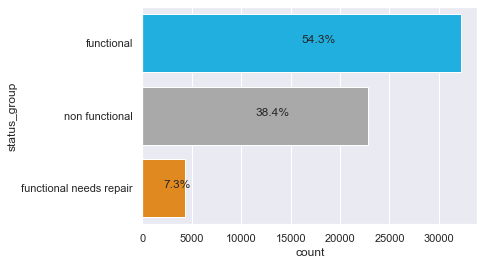

In [88]:
axes = sb.countplot(y = response['status_group'],palette=['deepskyblue','darkgrey','darkorange'])
total = len(response['status_group'])
for p in axes.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = (p.get_x() + p.get_width()) / 2
        y = p.get_y() + p.get_height()/2
        axes.annotate(percentage, (x, y))

- there is an imbalanced dataset, where 'functional needs repair' is the minority class

This will be rectified by artificially generating more samples with `function needs repair` and `non functional` to have the same ratio of the 3 classes

<a id='categoriceda'></a>
## Categoric EDA
<a href='#top'>Back to top</a>

In [89]:
categoricalEDA= waterData.select_dtypes(include = ['object'])
print("Number of Levels: ")
print()
for col in categoricalEDA:
    print('{:<30}: {}'.format(col,len(categoricalEDA[col].unique())))

Number of Levels: 

date_recorded                 : 356
funder                        : 1898
installer                     : 2146
wpt_name                      : 37400
basin                         : 9
subvillage                    : 19288
region                        : 21
lga                           : 125
ward                          : 2092
public_meeting                : 3
recorded_by                   : 1
scheme_management             : 13
scheme_name                   : 2697
permit                        : 3
extraction_type               : 18
extraction_type_group         : 13
extraction_type_class         : 7
management                    : 12
management_group              : 5
payment                       : 7
payment_type                  : 7
water_quality                 : 8
quality_group                 : 6
quantity                      : 5
quantity_group                : 5
source                        : 10
source_type                   : 7
source_class                  : 

- Predictors like `funder` and `installer` have too many levels (in the thousands and above)

Such predictors have too much variance and there are two ways to go about this:
- do not use them as features
- reduce the variance by collapsing the levels before using them

We will be performing either of these steps in data cleaning based on the respective features.

In [90]:
# we will visualise predictors with less than 22 levels first
mask = categoricalEDA.apply(lambda x:len(x.unique())<22)
lesserLevelsEDA=categoricalEDA.filter(categoricalEDA.columns[mask])
lesserLevelsEDA=pd.concat([lesserLevelsEDA,response],axis=1)

C:\Users\tanch\Anaconda3\lib\site-packages\seaborn\axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


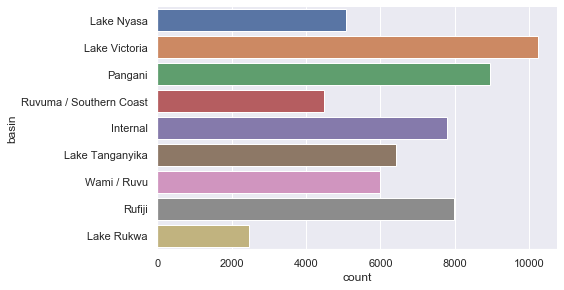

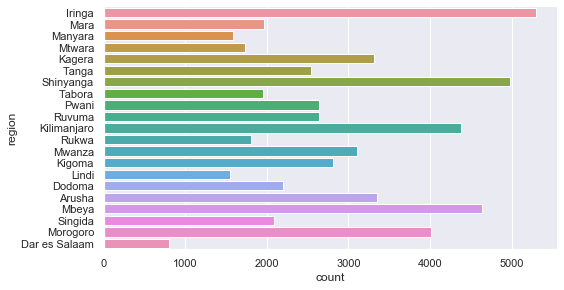

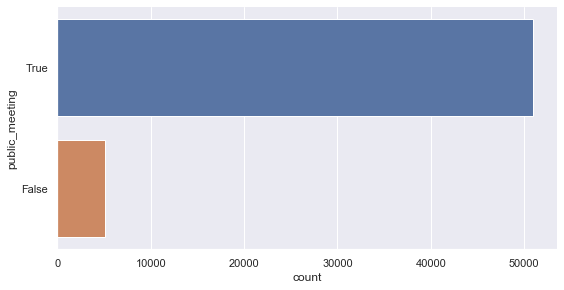

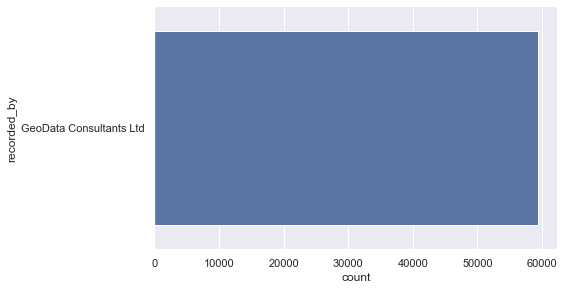

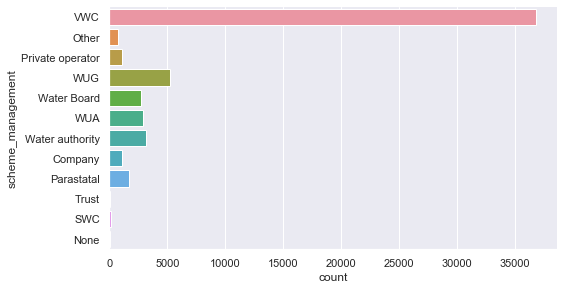

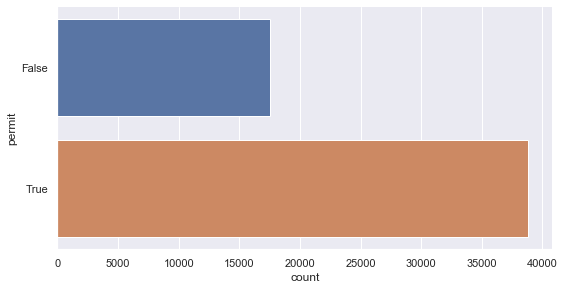

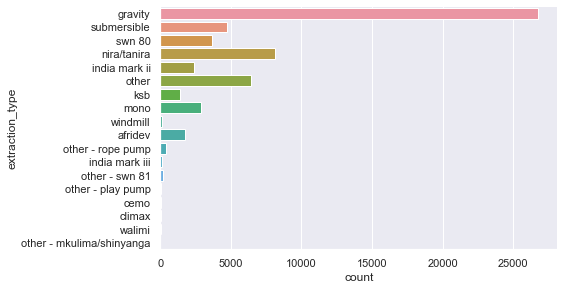

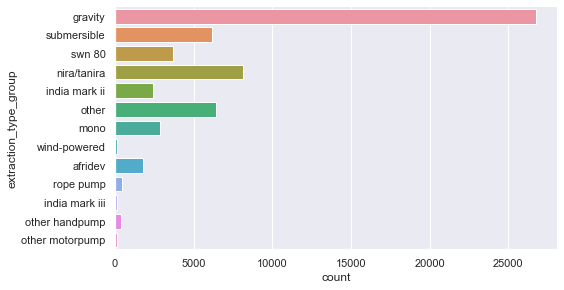

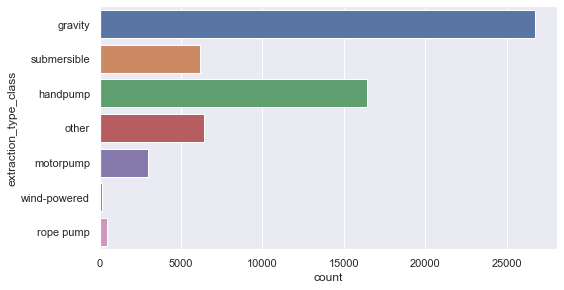

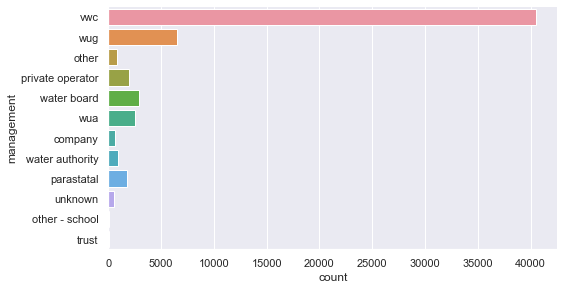

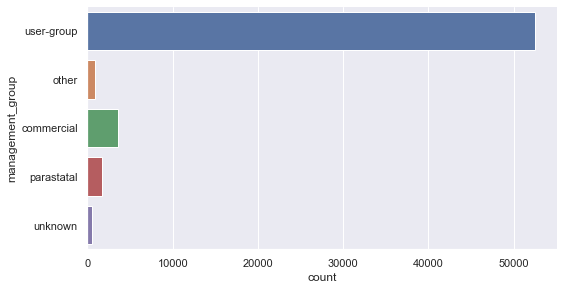

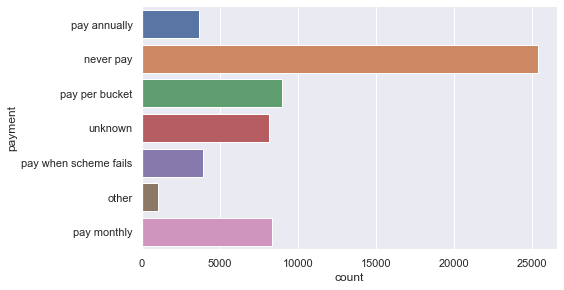

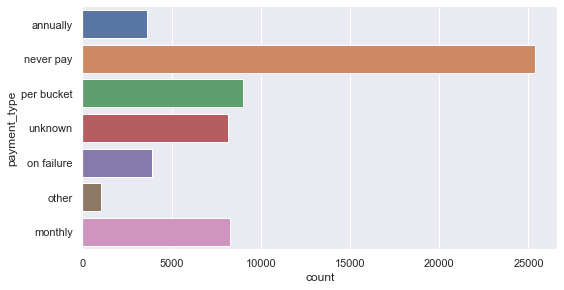

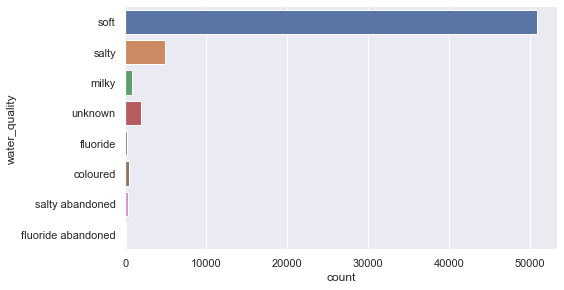

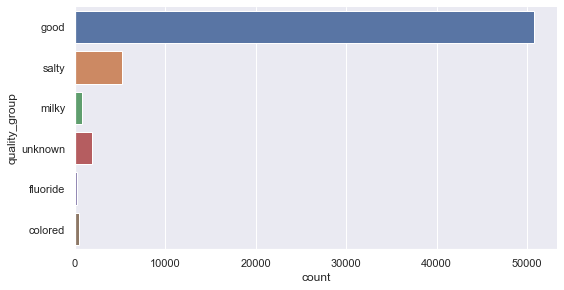

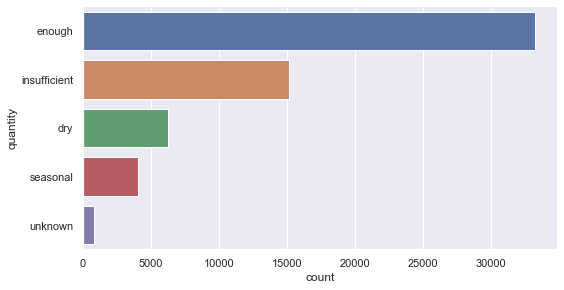

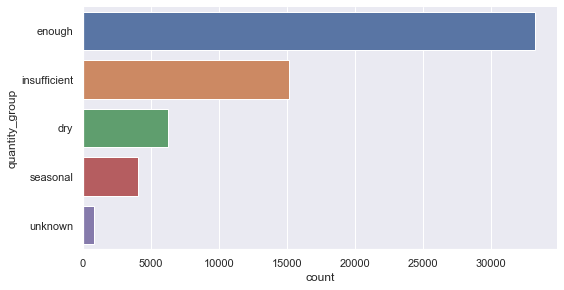

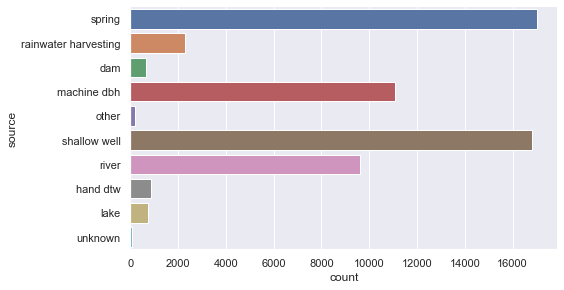

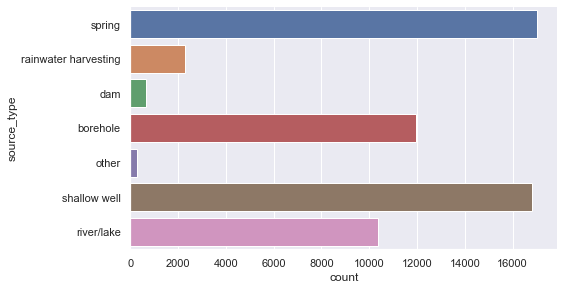

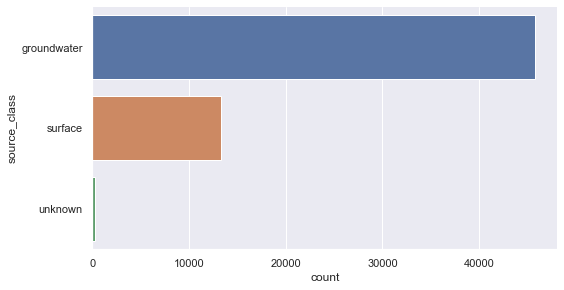

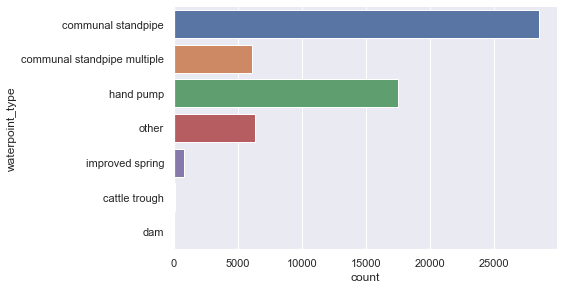

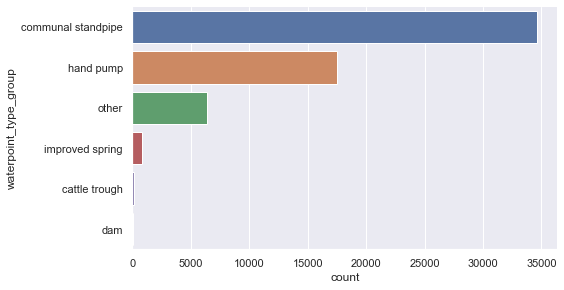

In [91]:
for col in lesserLevelsEDA.iloc[:,:-1]:
    sb.catplot(y=col,data=lesserLevelsEDA,kind='count',aspect=2,height=4)

- `recorded_by` only has got one level

Since this will not help in prediction, we will drop it

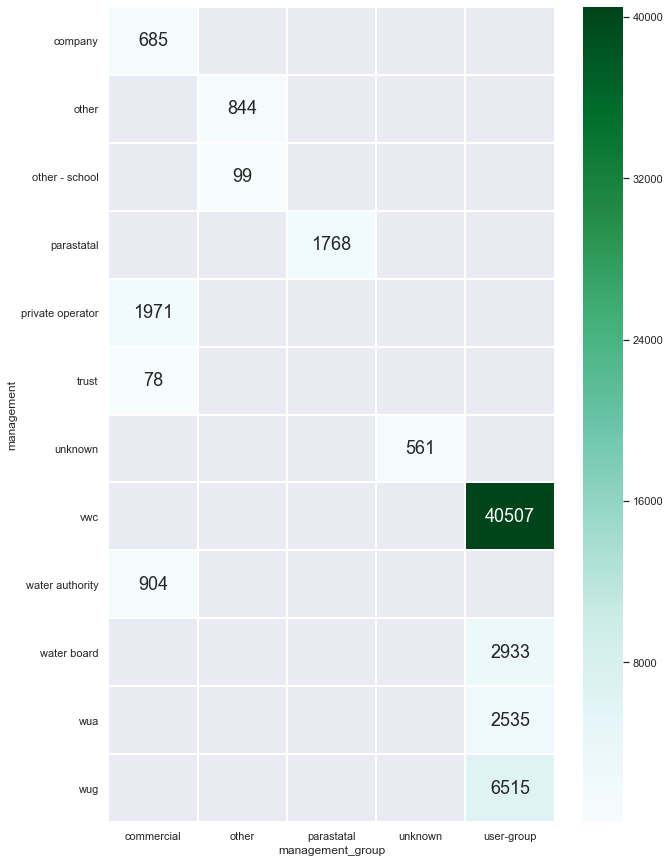

In [92]:
f, axes = plt.subplots(1, 1, figsize=(10, 15))
sb.heatmap(lesserLevelsEDA.groupby(['management', 'management_group']).size().unstack(), 
           linewidths = 1, annot = True,fmt='g', annot_kws = {"size": 18}, cmap = "BuGn")
def fix_heatmap():
    bottom, top = plt.ylim()
    bottom += .5
    top -= .5
    plt.ylim(bottom, top)
    plt.show()
fix_heatmap()

- some levels of `management_group` are IDENTICAL to those in `management` such as `unknown`
- `other` and `other-school` in `management` forms an improper subset of `other` in `management_group`

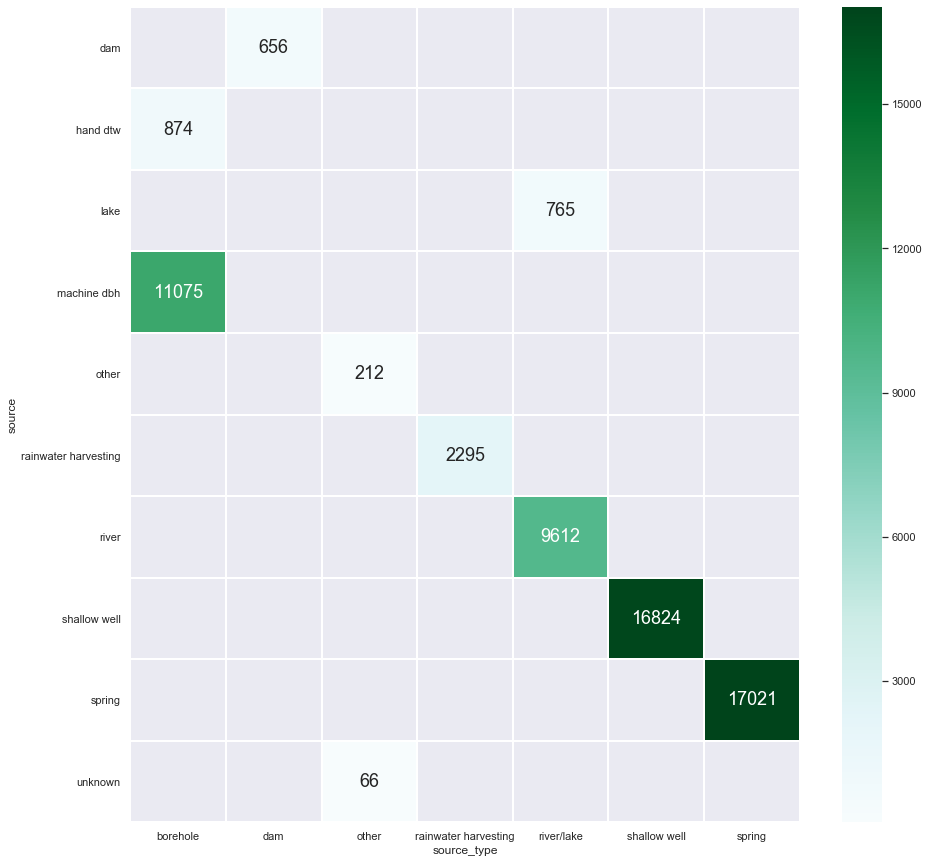

In [93]:
f, axes = plt.subplots(1, 1, figsize=(15, 15))
sb.heatmap(lesserLevelsEDA.groupby(['source', 'source_type']).size().unstack(), 
           linewidths = 1, annot = True,fmt='g', annot_kws = {"size": 18}, cmap = "BuGn")
fix_heatmap()

- similarly, `source` and `source_type` has identical levels and improper subsets

As it is difficult to say which 2 features of each pair compared above are better, we will keep both and let the model decide

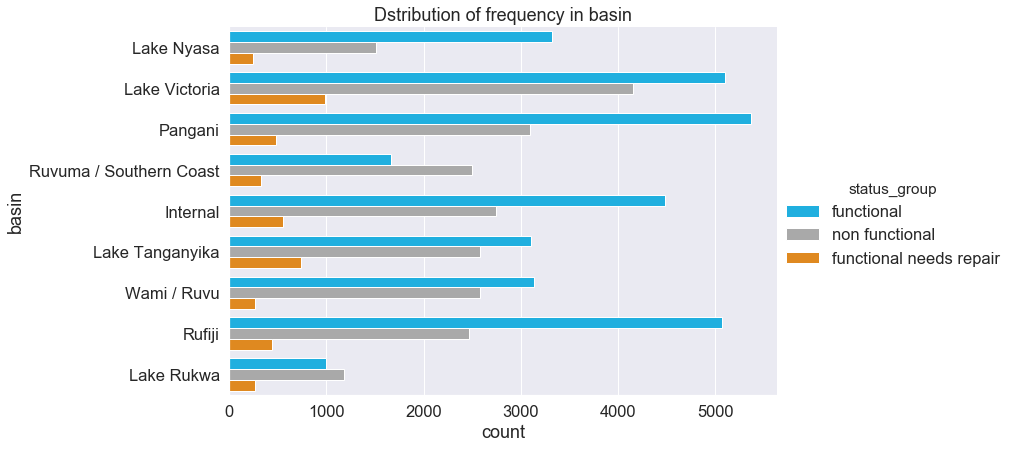

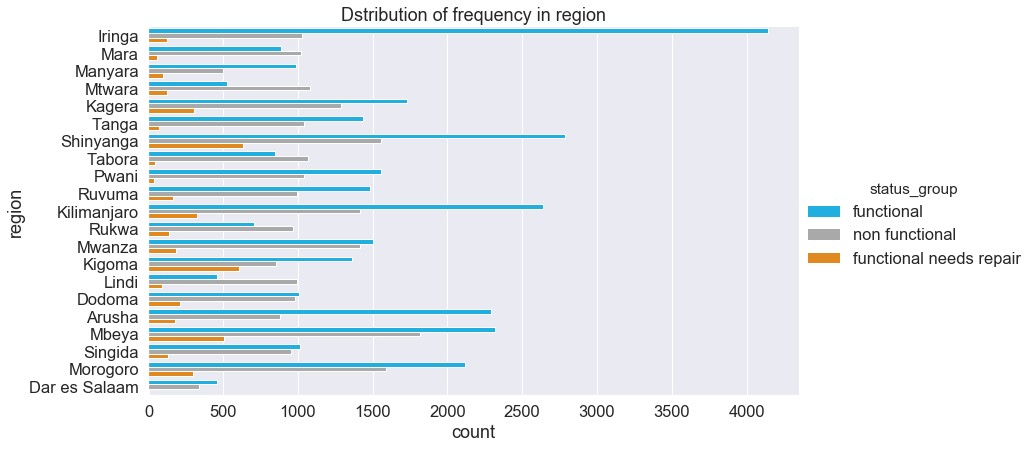

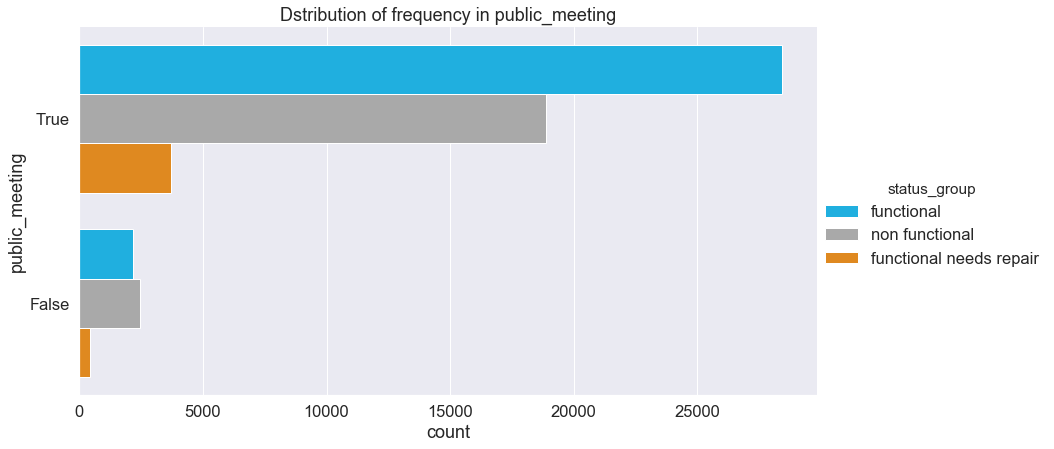

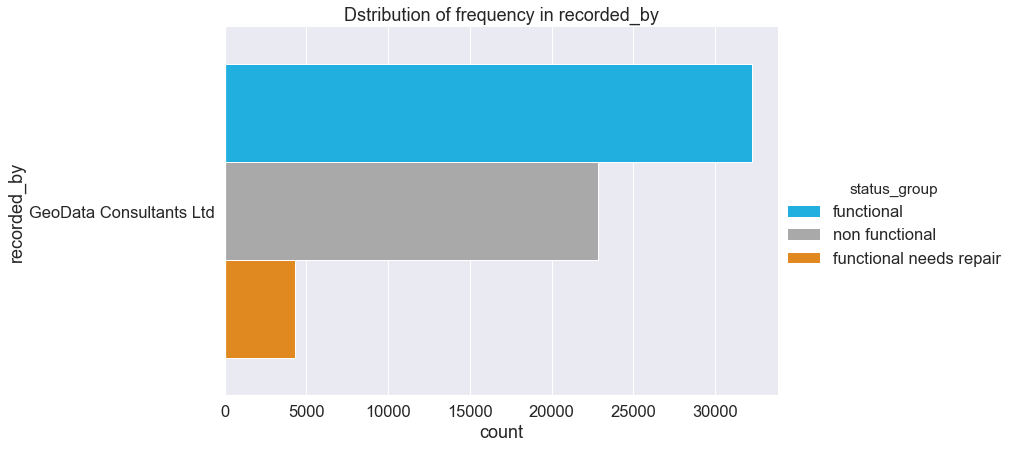

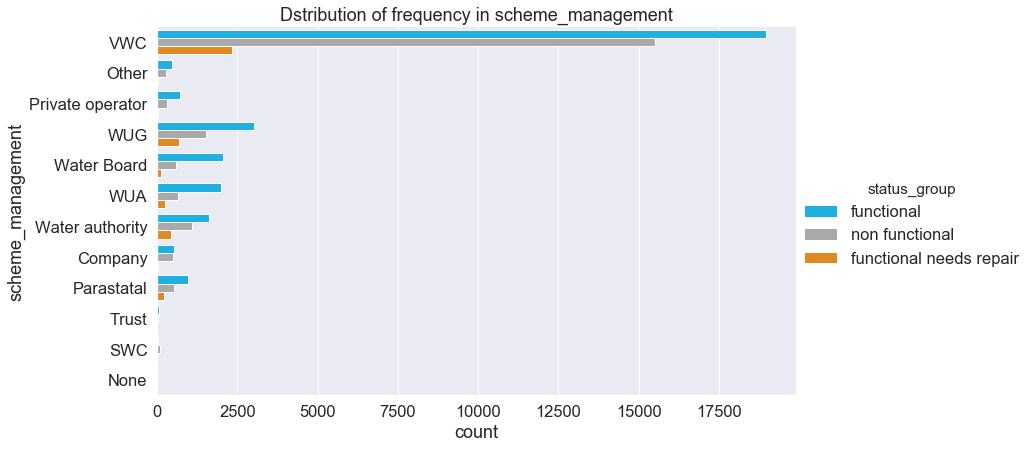

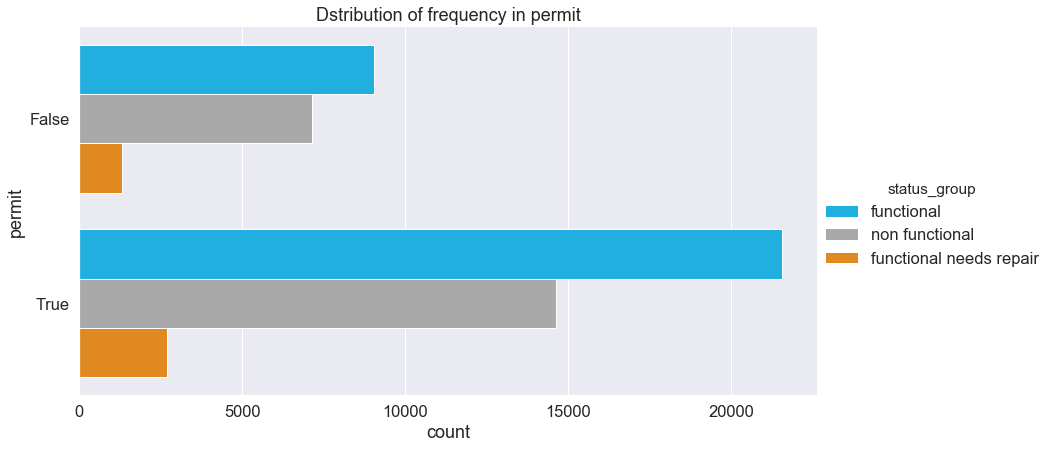

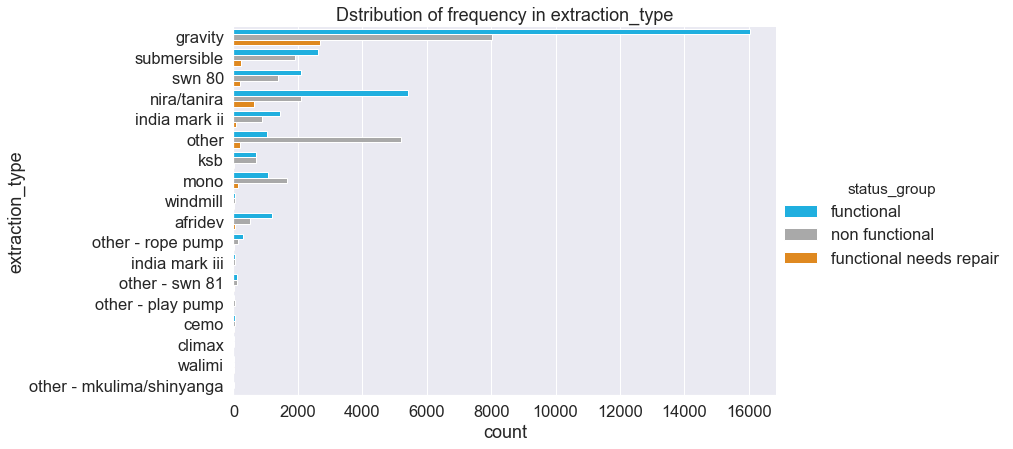

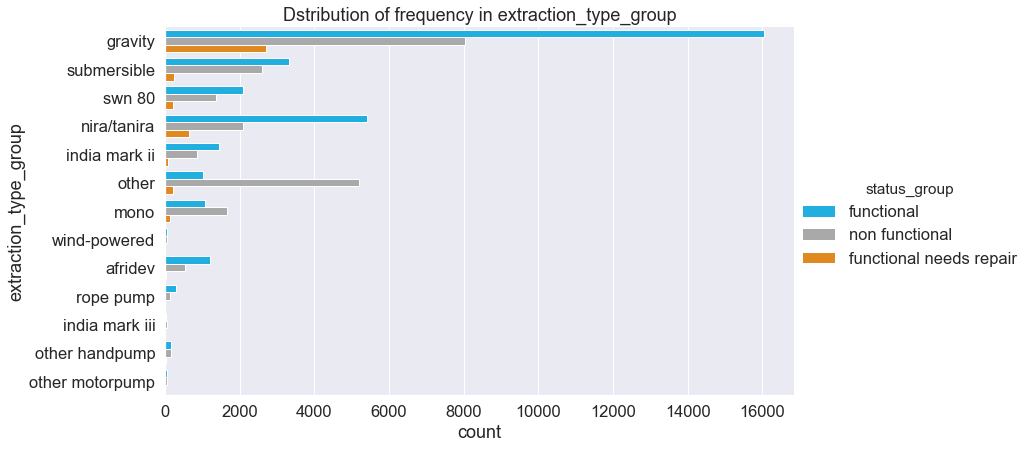

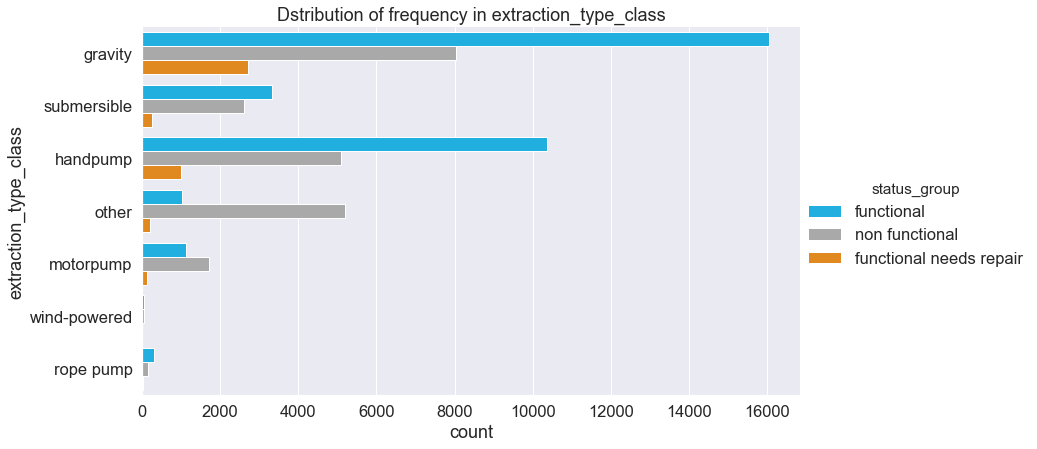

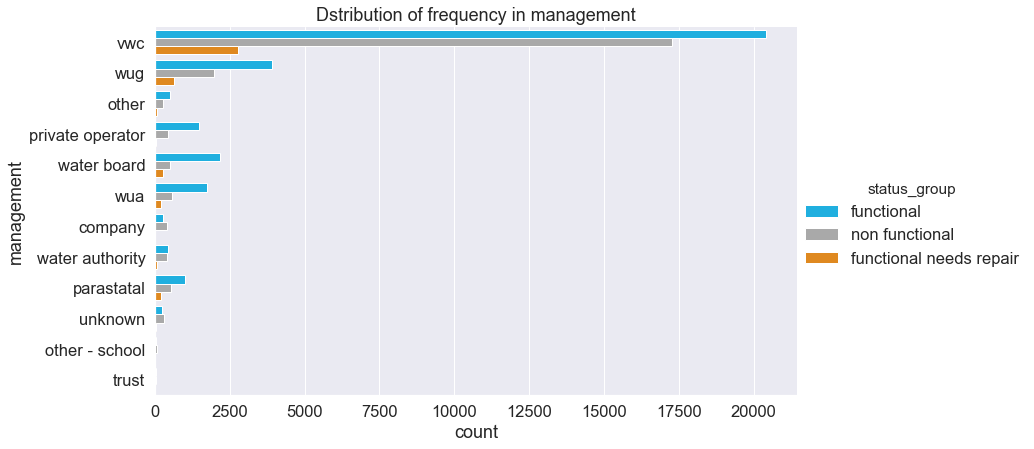

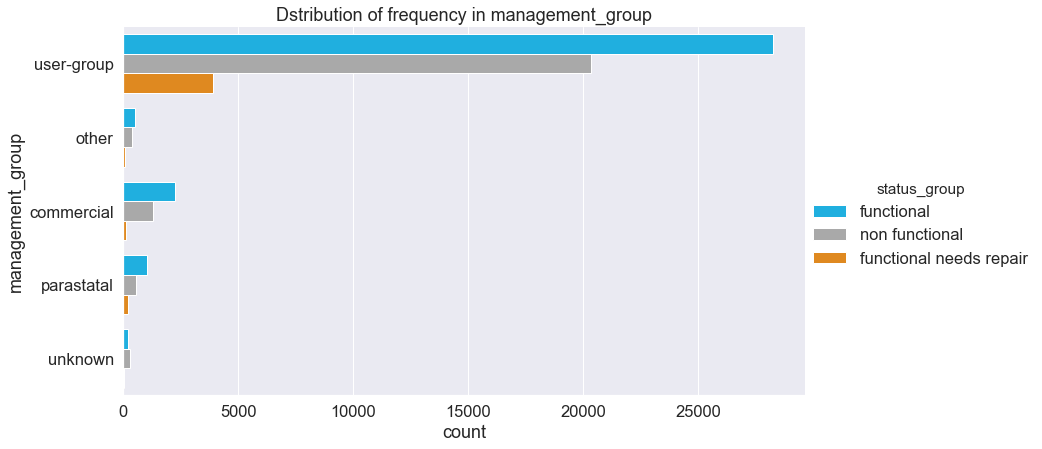

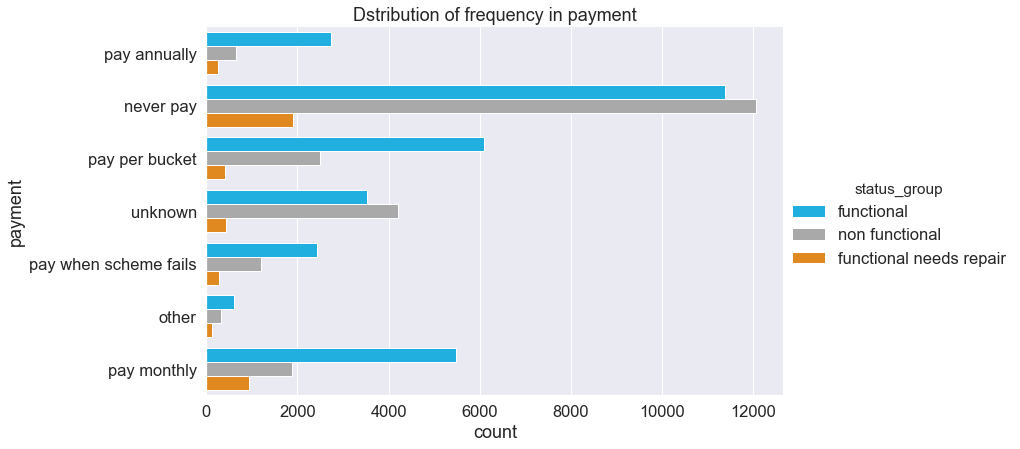

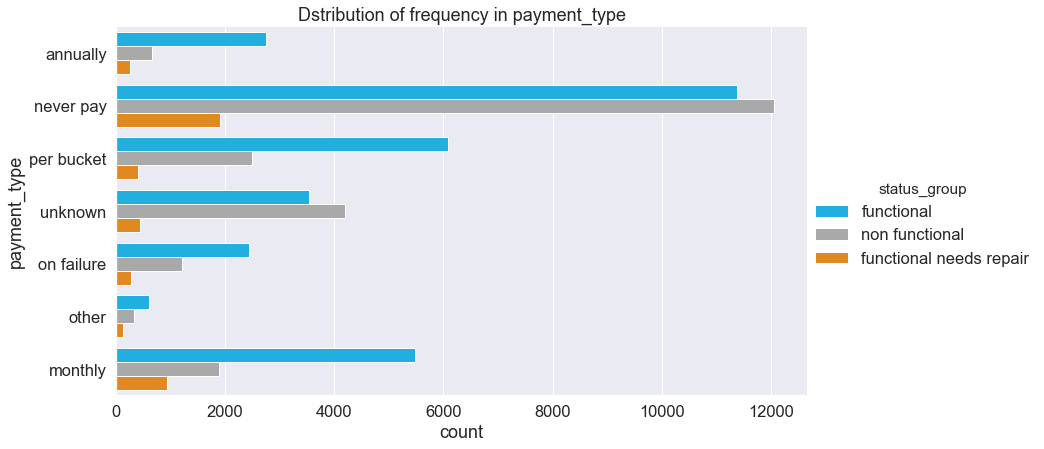

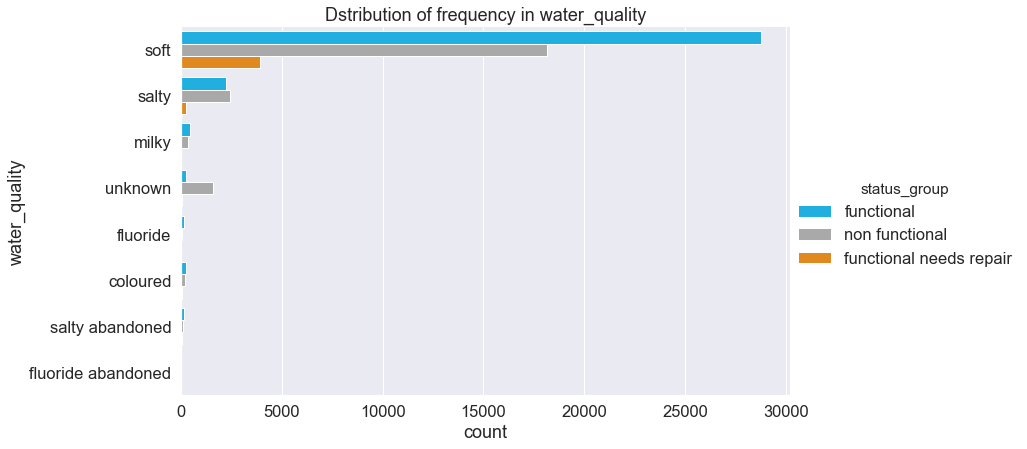

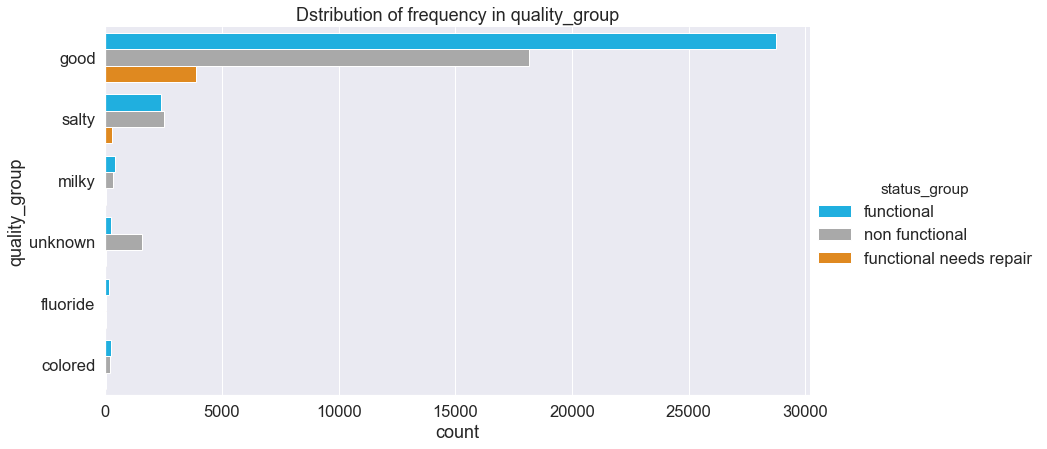

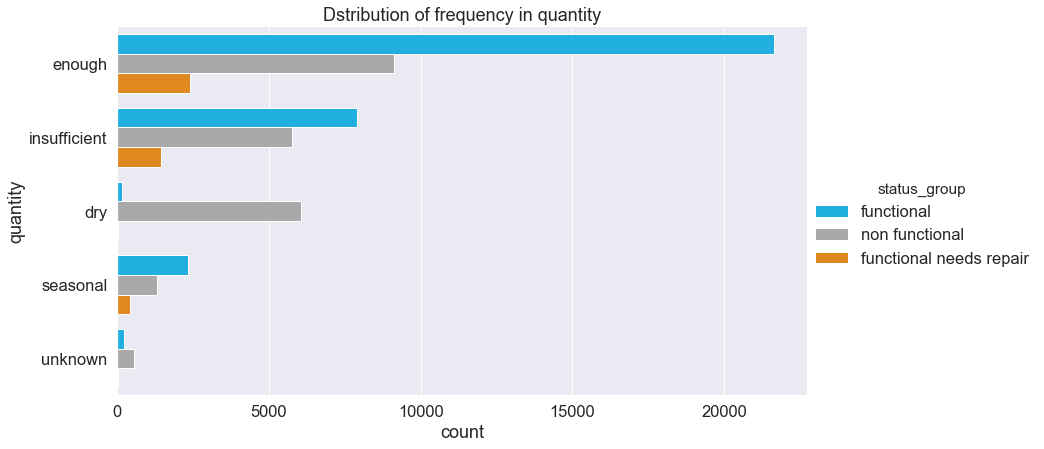

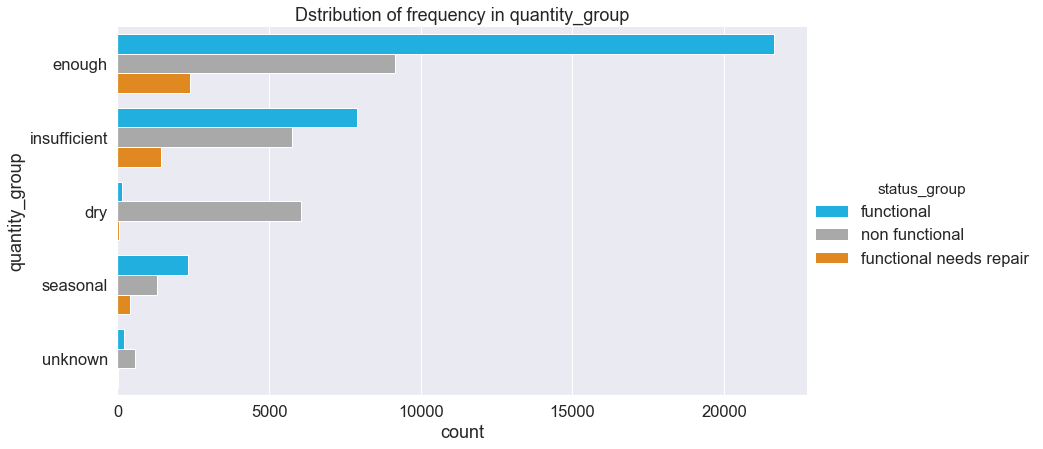

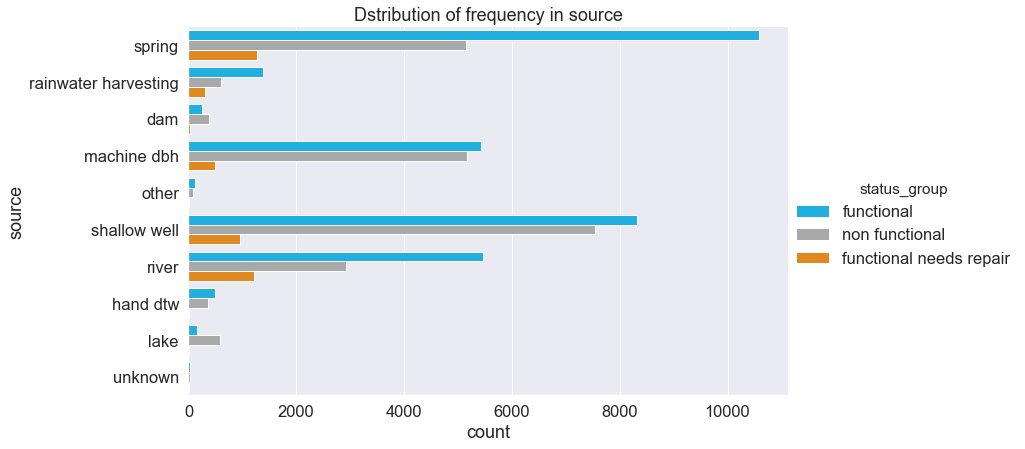

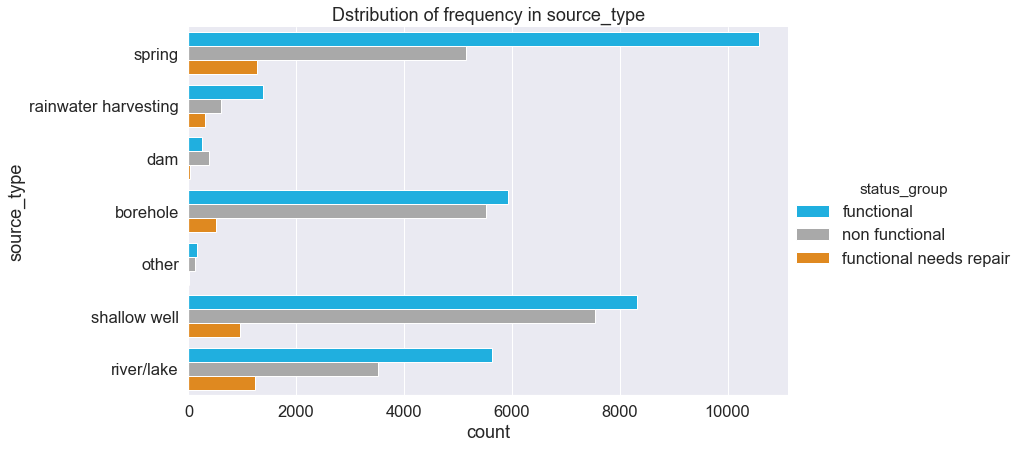

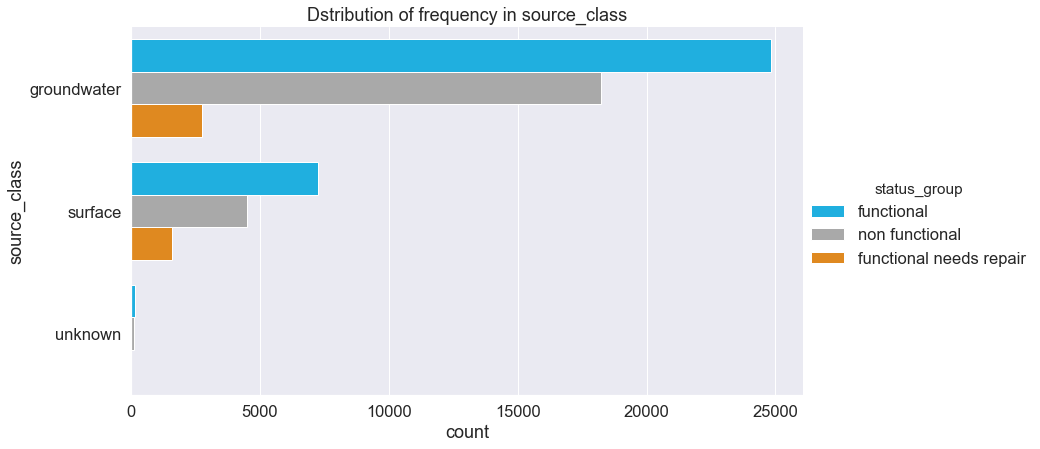

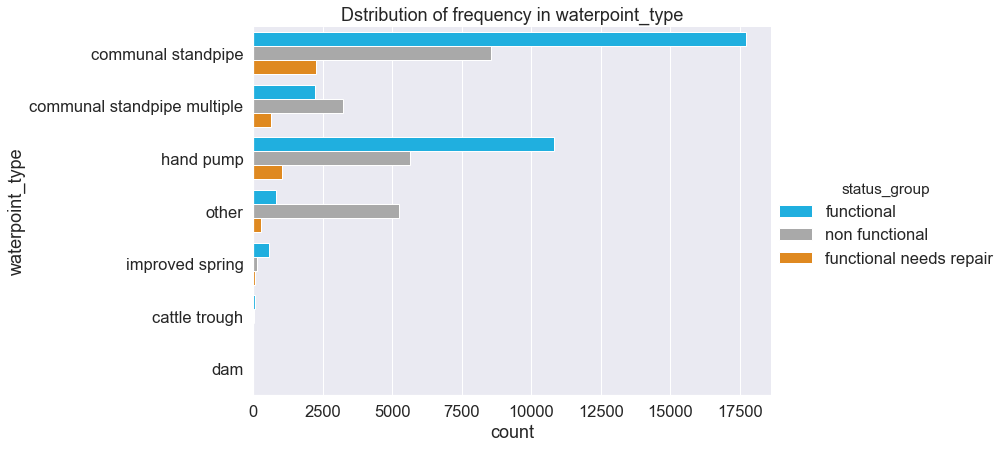

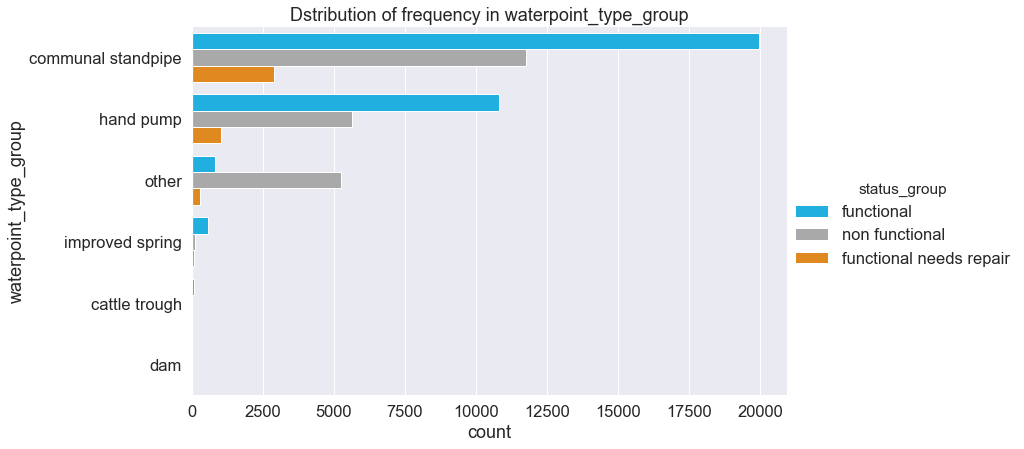

In [94]:
sb.set(font_scale=1.5)
for col in lesserLevelsEDA.iloc[:,:-1]:
    sb.catplot(y = col, hue='status_group',
               data = lesserLevelsEDA,
               kind = "count", height = 6,aspect=2,
               palette=['deepskyblue','darkgrey','darkorange'])
    plt.title('Dstribution of frequency in ' + col)
sb.set()

Some features appear good at distinguishing between the classes of `status_group`:
- Looking at 'waterpoint_type', a water pump belonging to 'other' is likely to be non-functional
- Looking at 'quality', a water pump belonging to 'dry' is likely to be non-functional

<a id='numericeda'></a>
## Numeric EDA
<a href='#top'>Back to top</a>

In [95]:
numericEDA=waterData.select_dtypes(exclude = ['object'])
numericEDA=pd.concat([numericEDA,response],axis=1)
numericEDA.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,functional
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010,functional
2,34310,25.0,686,37.460664,-3.821329,0,21,4,250,2009,functional
3,67743,0.0,263,38.486161,-11.155298,0,90,63,58,1986,non functional
4,19728,0.0,0,31.130847,-1.825359,0,18,1,0,0,functional


- Since `num_private` has no description and thus no explainability in the drivendata site, we will be dropping it

In [96]:
# remove scientific notation from 'latitude' and 'longitude' columns
numericEDA['latitude']=numericEDA['latitude'].round(6)
numericEDA['longitude']=numericEDA['longitude'].round(6)

In [97]:
# longitude 0, latitude 0, population 0 and negative gps_height seem quite suspicious
numericEDA.iloc[:,1:].describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-11.649440,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540622,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021596,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326155,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-0.000000,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [98]:
numericEDA[numericEDA['longitude']==0].head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
21,6091,0.0,0,0.0,-0.0,0,17,1,0,0,functional
53,32376,0.0,0,0.0,-0.0,0,19,6,0,0,non functional
168,72678,0.0,0,0.0,-0.0,0,17,1,0,0,functional
177,56725,0.0,0,0.0,-0.0,0,17,1,0,0,non functional
253,13042,0.0,0,0.0,-0.0,0,19,2,0,0,functional needs repair


In [99]:
numericEDA[numericEDA['longitude']==0].shape

(1812, 11)

- `amount_tsh`, `gps_height`, `longitude`, `latitude`, `population` and `construction_year` appear to all be 0

We suspect that this is NOT a natural value, in other words, this 1812 data points are in fact N.A values. We will fill them accordingly later

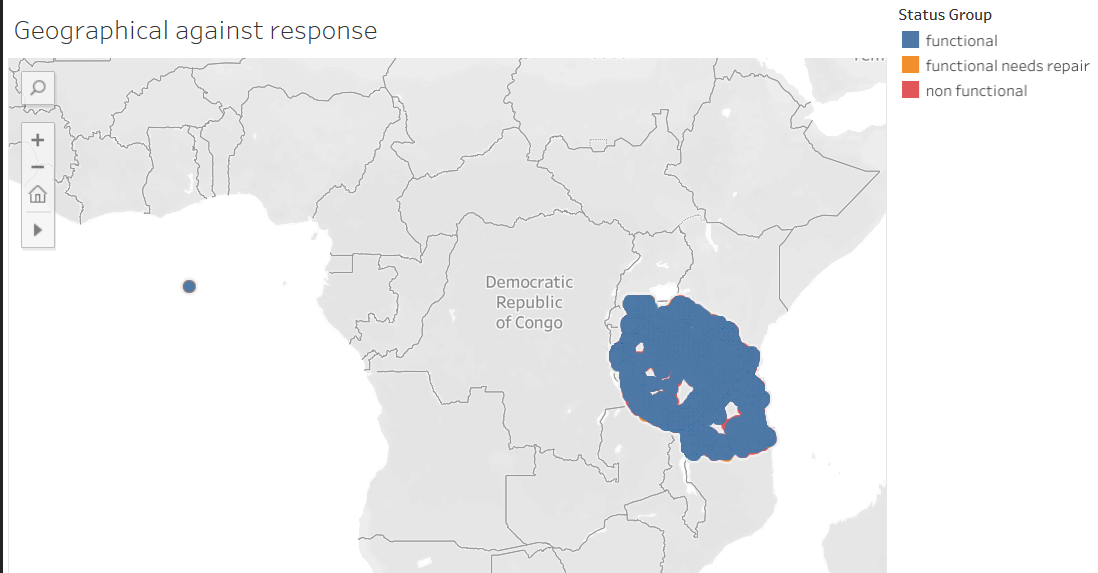

In [100]:
from IPython.display import Image
Image(filename='latLongZero.png')

- indeed coordinates 0,0 are unrecorded values, will attempt to replace them accurately based on other available geometric variables

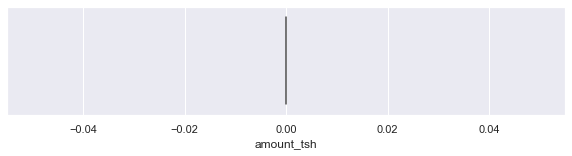

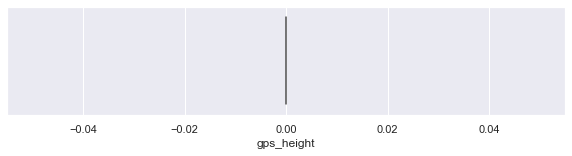

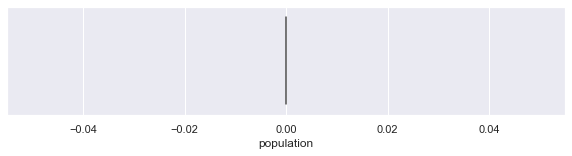

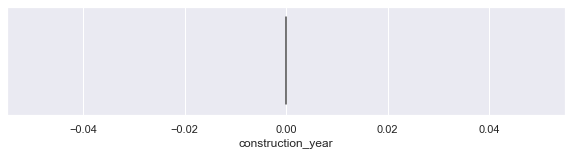

In [101]:
for col in ['amount_tsh', 'gps_height', 'population', 'construction_year']:
    f, axes = plt.subplots(1, 1, figsize = (10, 2))
    sb.violinplot(numericEDA[(numericEDA['latitude']==0)|(numericEDA['longitude']==0)][col])

- indeed rows with 'latitude' and 'longitude' zero means that other variables were also NOT recorded

In [102]:
# 'region_code','district_code','construction_year' seem to be categoric so we visualise separately
numericEDA=numericEDA.drop(['region_code','district_code','construction_year'],axis=1)

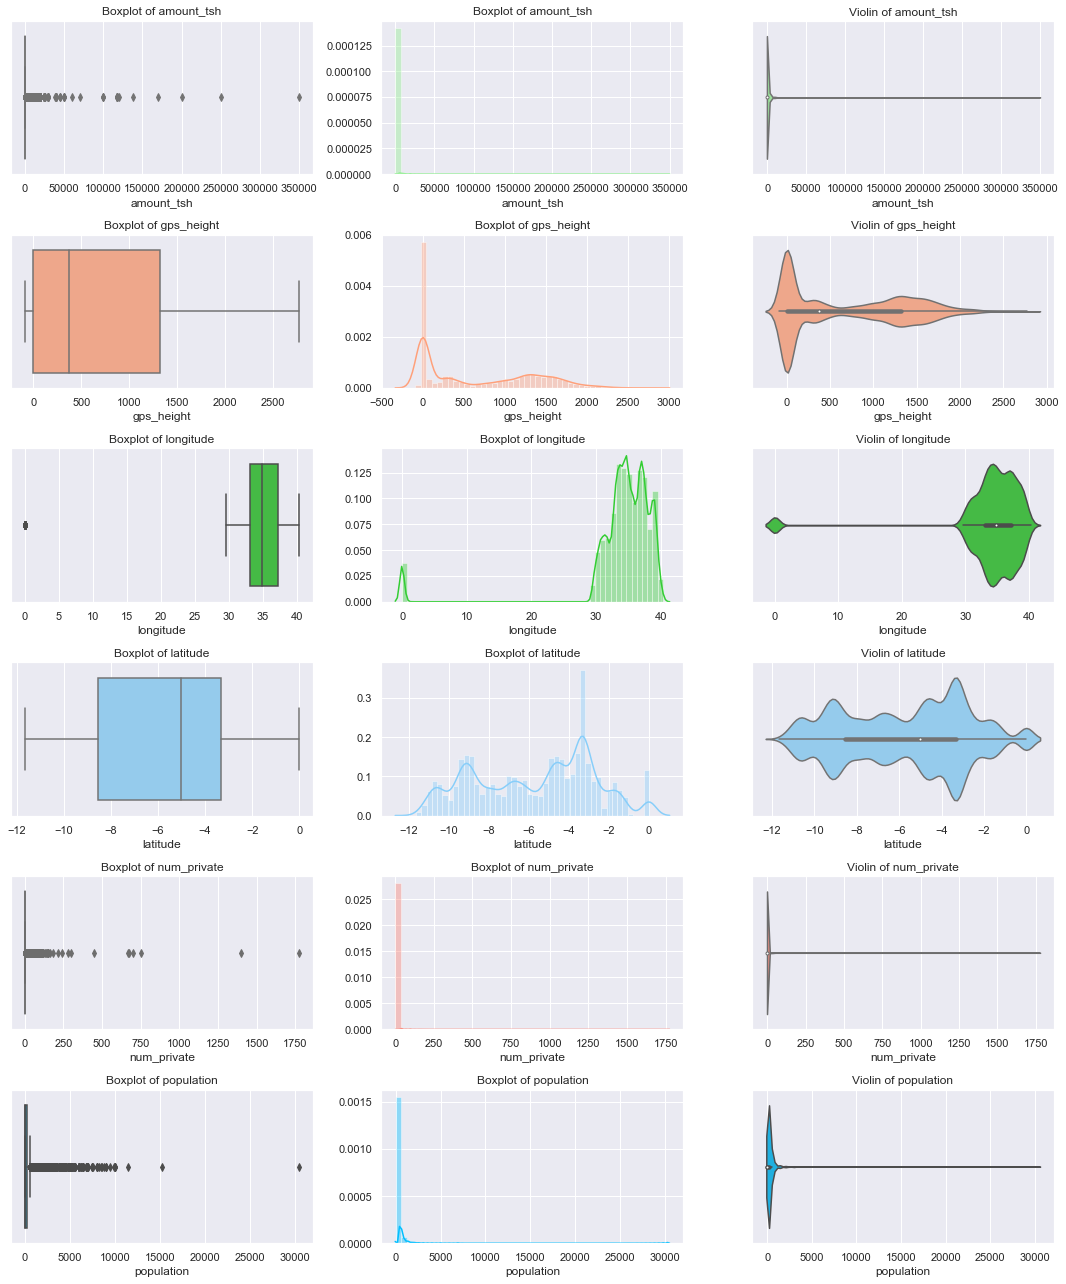

In [103]:
def univariate_numeric_plots(data,color):
    multiplier = len(data.columns)
    f, axes = plt.subplots(multiplier, 3, figsize = (15, 3*multiplier))
    
    for i, col in enumerate(data):
        sb.boxplot(data[col], color = color[i], ax = axes[i, 0])
        axes[i, 0].set_title('Boxplot of ' + col)
        sb.distplot(data[col], color = color[i], ax = axes[i, 1])
        axes[i, 1].set_title('Boxplot of ' + col)
        sb.violinplot(data[col], color = color[i], ax = axes[i, 2])
        axes[i, 2].set_title('Violin of ' + col)
    plt.tight_layout()
color_list=['lightgreen','lightsalmon','limegreen','lightskyblue','salmon',"deepskyblue"]
univariate_numeric_plots(numericEDA.iloc[:, 1:-1], color_list)

- 'amount_tsh' median are both 0 while median population is close to 0
- indeed, longitude and latitude seem to be abnormalies, so we will replace them by other geometric features

In [104]:
def numericAgainstResponse(data, figsize = None, palette = ['deepskyblue','darkgrey','darkorange']):
    sb.set(font_scale=1.4)
    multiplier = len(data.iloc[:, :-1].columns)
    f, axes = plt.subplots(multiplier, 2, figsize=(figsize[0]*multiplier,figsize[1]*multiplier))
    
    for i, col in enumerate(data.iloc[:, :-1]):
        sb.boxplot(x=col,y='status_group',data=data,palette=palette, ax = axes[i, 0])
        axes[i, 0].set_title(f'Boxplot of {col} against response' )
        sb.violinplot(x=col,y='status_group',data=data,palette=palette, ax = axes[i, 1])
        axes[i, 1].set_title(f'Violinplot of {col} against response')
    plt.tight_layout()
    sb.set()

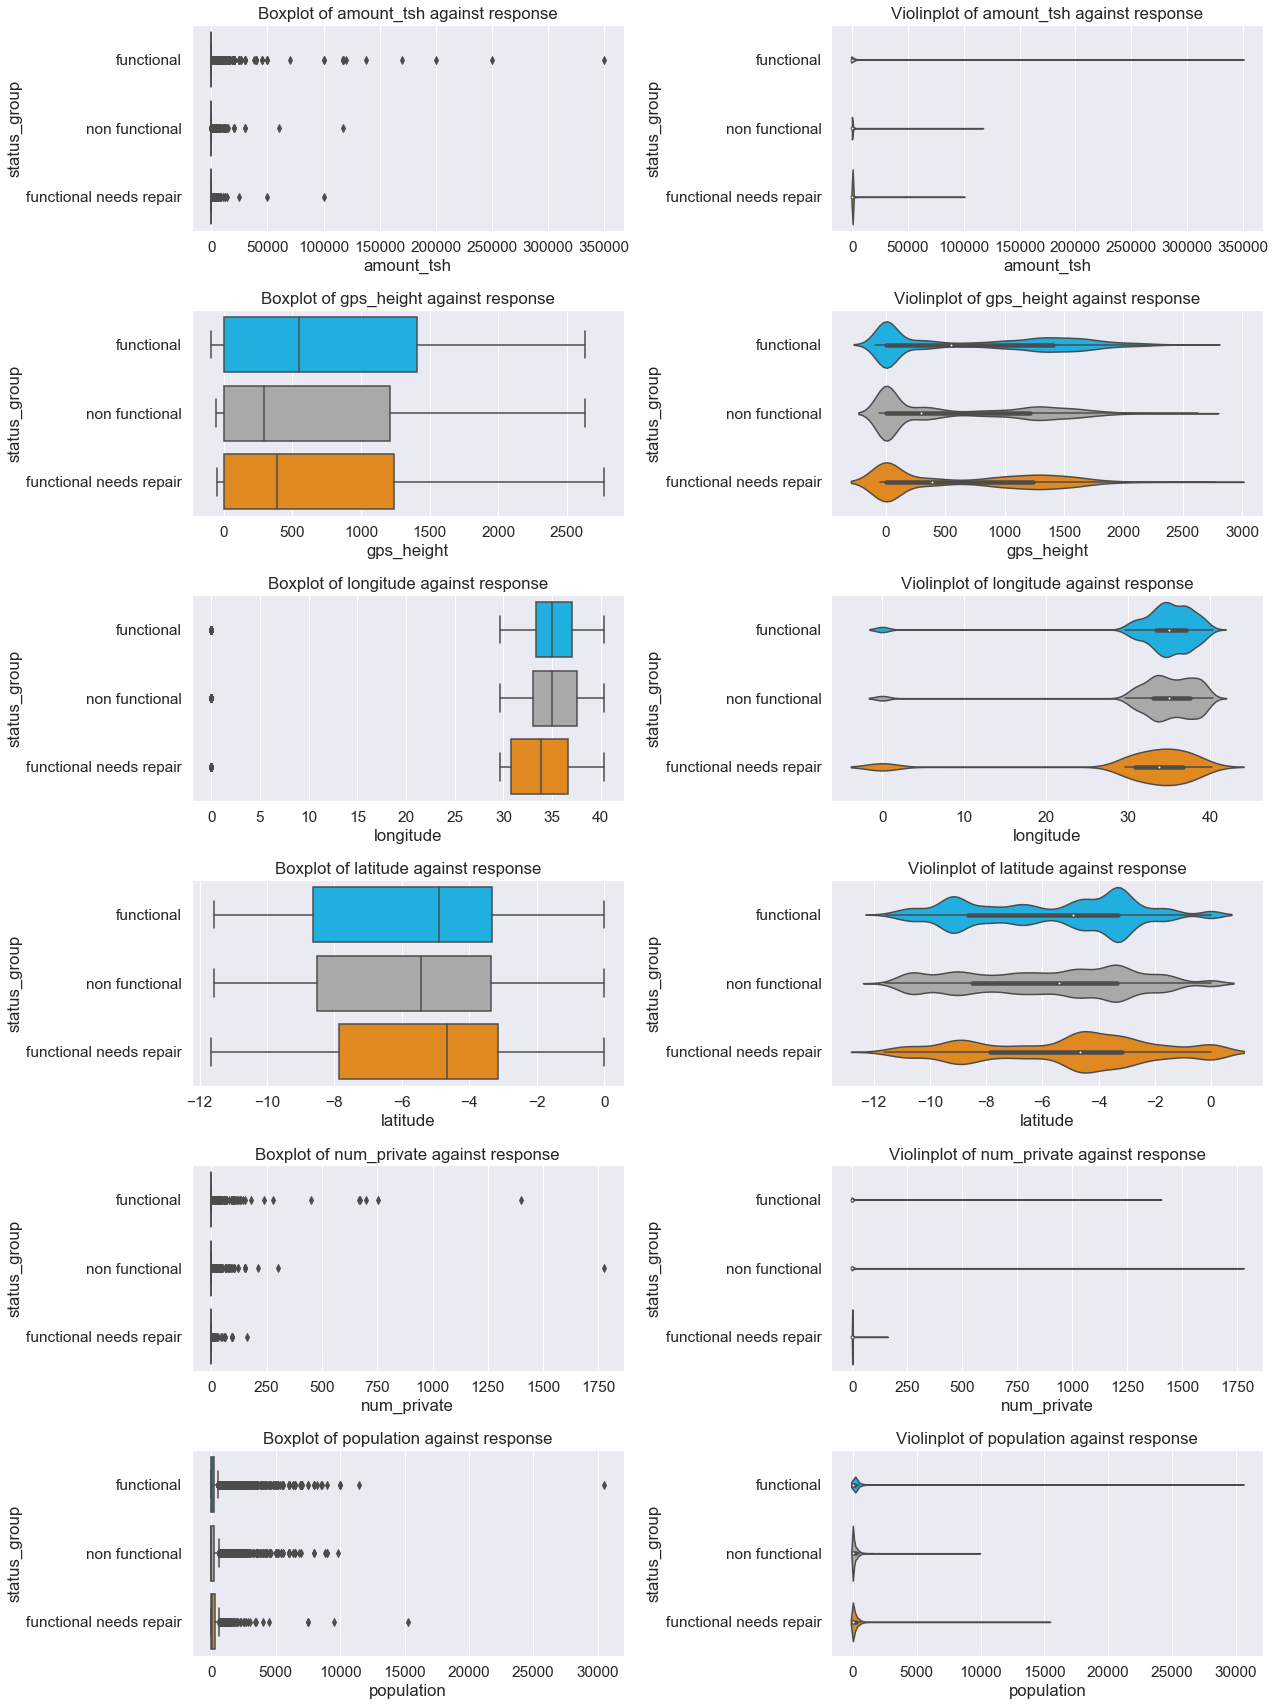

In [105]:
numericAgainstResponse(numericEDA.iloc[:, 1:], figsize = (3, 4))

- Based on the plots above, above 125000 `amount_tsh` or above 16000 `population`, water pumps are mostly functional

Let's take a closer look at the **geological features** using density plots for more meaningful insights

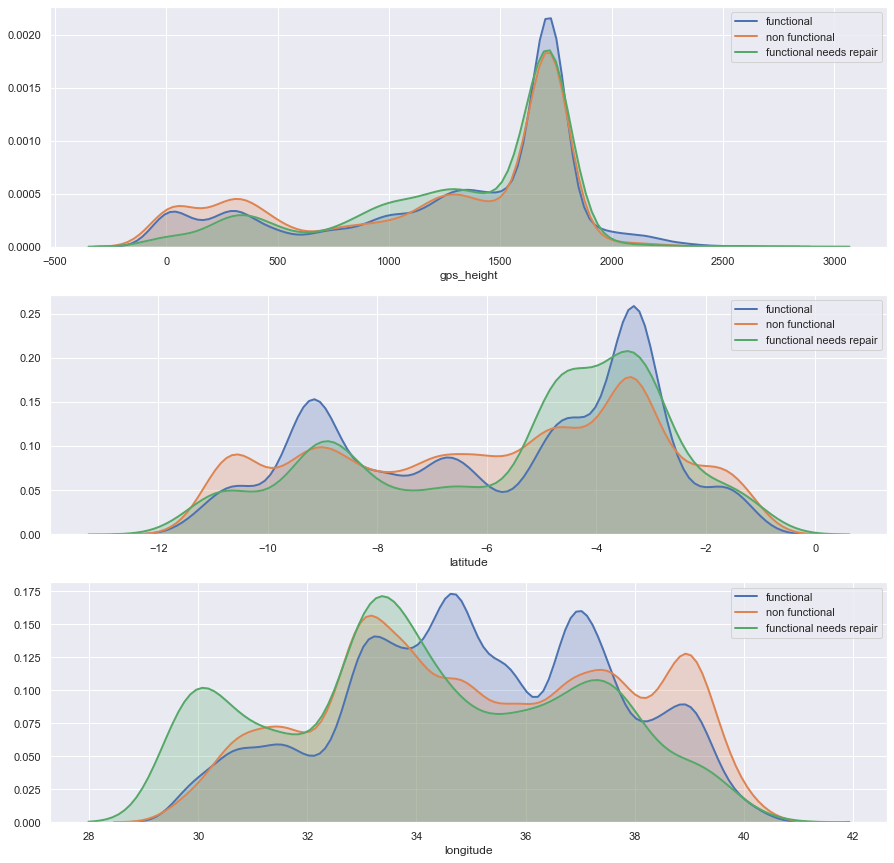

In [171]:
f, axes = plt.subplots(3, 1, figsize = (15, 15))
for i,predictor in enumerate(['gps_height','latitude','longitude']):
    for level in response['status_group'].unique():
        sb.distplot(numericData[response['status_group']==level][predictor],
                    hist=False,
                    kde_kws = {'shade': True, 'linewidth': 2},
                    label=level,
                    ax = axes[i])

Certain intervals do have **higher area under curve**, indicating a **higher likelihood** of being a certain status_group. 
- Most prominently, water pumps at longitude of below 31 is more likely to be needing repair.
- Also, water pumps below 500 gps_height is more likely to be non-functional
- we will keep these variables as they seem to be moderately good predictors

## Remaining Categoric EDA
- exploring and visualising `region_code` and `district_code`

In [106]:
categoricalEDA = pd.concat([categoricalEDA, waterData[['region_code', 'district_code']],
                            response['status_group']], axis = 1)
categoricalEDA.head()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,region_code,district_code,status_group
0,2011-03-14,Roman,Roman,none,Lake Nyasa,Mnyusi B,Iringa,Ludewa,Mundindi,True,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,11,5,functional
1,2013-03-06,Grumeti,GRUMETI,Zahanati,Lake Victoria,Nyamara,Mara,Serengeti,Natta,NaN,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,20,2,functional
2,2013-02-25,Lottery Club,World vision,Kwa Mahundi,Pangani,Majengo,Manyara,Simanjiro,Ngorika,True,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,21,4,functional
3,2013-01-28,Unicef,UNICEF,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,Nanyumbu,Nanyumbu,True,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,90,63,non functional
4,2011-07-13,Action In A,Artisan,Shuleni,Lake Victoria,Kyanyamisa,Kagera,Karagwe,Nyakasimbi,True,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,18,1,functional


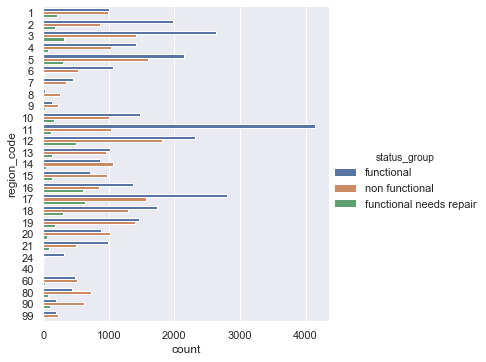

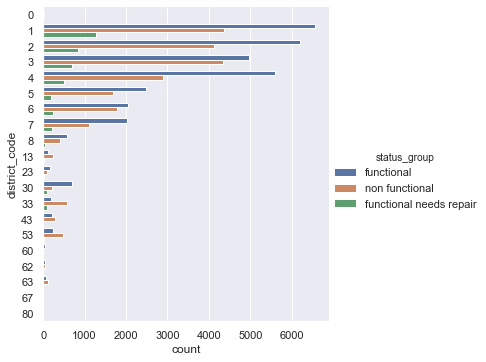

In [107]:
for col in ['region_code','district_code']:
    sb.catplot(y=col,data=categoricalEDA,kind='count', hue = 'status_group')

Again, some levels seem to indicate state of water pump:
- `53` in `district_code` indicates water pump is likely to be `non functional`

<a id='datacleaning'></a>
# Data Cleaning
- <a href='#categoriccleaning'>Categoric Cleaning</a>
- <a href='#numericcleaning'>Numeric Cleaning</a>
- <a href='#featureengineering'>Feature Engineering</a>
- <a href='#standardizenumeric'>Standardize Numeric</a>
- <a href='#smote'>SMOTE</a>
- <a href='#finalvisualization'>Final Visualization</a>
---
<a href='#top'>Back to top</a>

<a id='categoriccleaning'></a>
### Categoric Cleaning
As mentioned, we will:
- drop all categoric features with > 30 levels
- drop `recorded_by`
- fill N.A with `Missing` to indicate missing level
- apply str() to each column to intepret numbers in features like `region_code` to be read as objects
---
- <a href='#datacleaning'>Back to Data Cleaning</a>
- <a href='#top'>Back to top</a>

In [108]:
mask = categoricalEDA.apply(lambda x:len(x.unique())<31)
categoricalData = categoricalEDA.filter(categoricalEDA.columns[mask])
categoricalData.drop('recorded_by', axis = 1, inplace = True)
categoricalData.isna().sum()

basin                       0
region                      0
public_meeting           3334
scheme_management        3877
permit                   3056
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
region_code                 0
district_code               0
status_group                0
dtype: int64

As seen above and from the EDA, columns like `public_meeting` have only `True`, `False`, and `NA` values.

- if they only had `True` and `NA` values, the `NA`s would indicate absence of `public_meeting` and thus should be replaced with `False`
- However, this is not the case so we replace with `Missing` to indicate missing of data collected

In [109]:
categoricalData.fillna('Missing', inplace = True)
for col in categoricalData:
    categoricalData[col] = categoricalData[col].apply(lambda x: str(x))
categoricalData.head()

,basin,region,public_meeting,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,region_code,district_code,status_group
0,Lake Nyasa,Iringa,True,VWC,False,gravity,gravity,gravity,vwc,user-group,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,11,5,functional
1,Lake Victoria,Mara,Missing,Other,True,gravity,gravity,gravity,wug,user-group,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,20,2,functional
2,Pangani,Manyara,True,VWC,True,gravity,gravity,gravity,vwc,user-group,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,21,4,functional
3,Ruvuma / Southern Coast,Mtwara,True,VWC,True,submersible,submersible,submersible,vwc,user-group,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,90,63,non functional
4,Lake Victoria,Kagera,True,Missing,True,gravity,gravity,gravity,other,other,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,18,1,functional


Now we will collapse features with 10 < levels < 30 where we arbitrarily chose 10 and 30 to be the threshold.

Some intermediate steps:
- plot the frequency of occurence of each level in each feature
- manually group them by eye into N different new levels depending on the feature

---
Note:

We can remove the upper threshold and collapse features with more than 1000 levels.

However:

- little information that isn't already known will be gleaned from this
- since most features with more than 1000 levels are intuitively related to other simpler features
- such as `subvillage` with almost 20,000 levels being related to `longitude` and `latitude`
- in other words, modelling on the latter 2 features should be representative of different `subvillages`

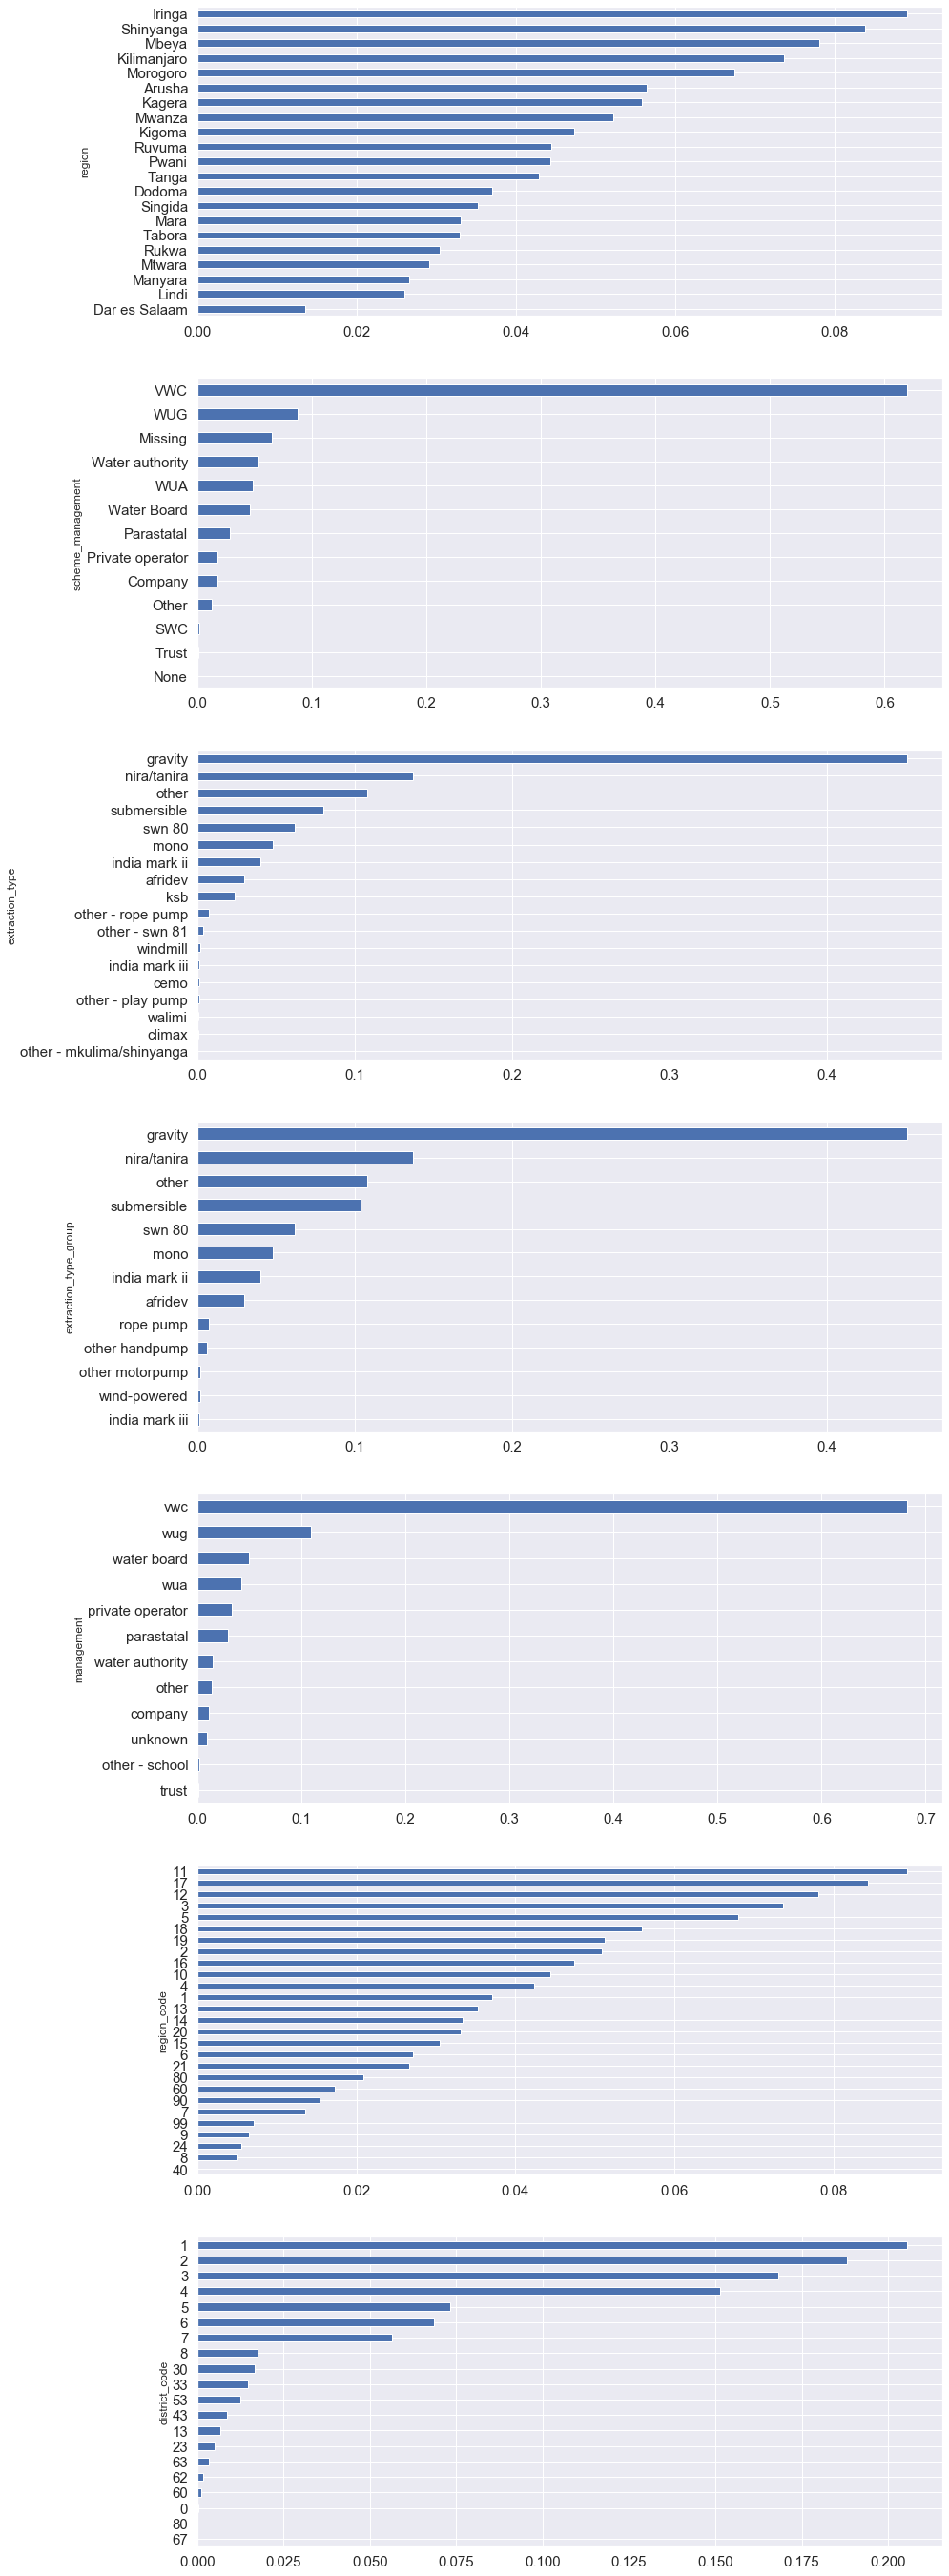

In [110]:
toPlot = {}
mask = categoricalData.apply(lambda x:10<len(x.unique())<30)
toCollapse = categoricalData.filter(categoricalData.columns[mask])

for col in toCollapse:
    fe = (toCollapse.groupby(col).size()/len(toCollapse)).sort_values(ascending = True)
    toPlot[col] = fe
multiplier = len(toPlot)
f, axes = plt.subplots(multiplier, 1, figsize = (2 * multiplier, 7 * multiplier))
for i, df in enumerate(toPlot.values()):
    df.plot(y = df, kind = 'barh', ax = axes[i], fontsize = 15)

As seen above:
- `region` has groups of dominating levels like `Iringa` to `Morogoro`
- `scheme_management` has one dominating level `VWC` of 60% occurence

- hard code each feature into the N respective groups
- visualize new levels

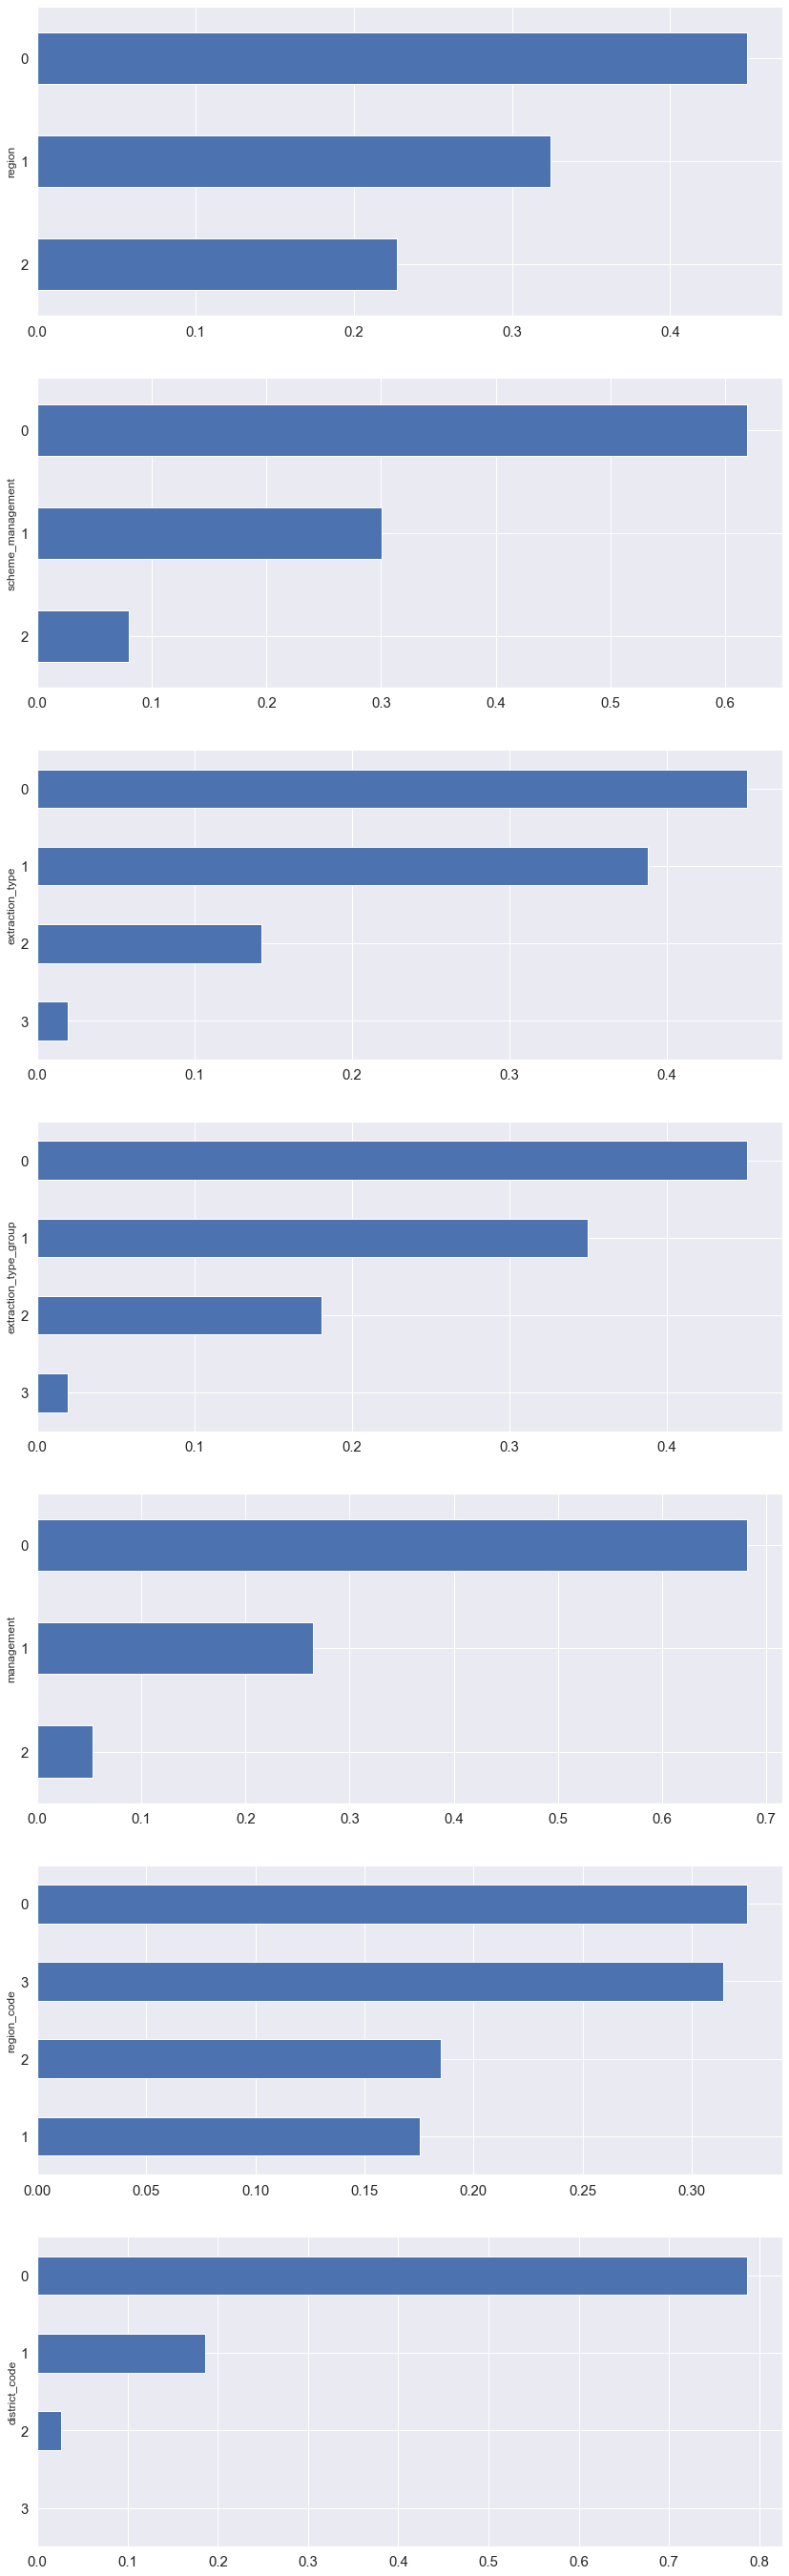

In [111]:
col = 'region'
# reverse as we are reading plot from top to bottom
levels = list(reversed(toPlot[col].index))
new_levels = [levels[:6], levels[6:-8], levels[-8:]]
def replace():
    mask = {}
    for index, levels in enumerate(new_levels):
        for level in levels:
            mask[level] = str(index)
    return mask
mask = replace()
toCollapse[col].replace(mask, inplace=True)

col = 'scheme_management'
levels = list(reversed(toPlot[col].index))
new_levels = [levels[0:1], levels[1:6], levels[6:]]
toCollapse[col].replace(replace(), inplace=True)

col = 'extraction_type'
levels = list(reversed(toPlot[col].index))
new_levels = [levels[0:1], levels[1:5], levels[5:9], levels[9:]]
toCollapse[col].replace(replace(), inplace=True)

col = 'extraction_type_group'
levels = list(reversed(toPlot[col].index))
new_levels = [levels[0:1], levels[1:4], levels[4:8], levels[8:]]
toCollapse[col].replace(replace(), inplace=True)

col = 'management'
levels = list(reversed(toPlot[col].index))
new_levels = [levels[0:1], levels[1:6], levels[6:]]
toCollapse[col].replace(replace(), inplace=True)

col = 'region_code'
levels = list(reversed(toPlot[col].index))
new_levels = [levels[0:4], levels[4:7], levels[7:11], levels[11:]]
toCollapse[col].replace(replace(), inplace=True)

col = 'district_code'
levels = list(reversed(toPlot[col].index))
new_levels = [levels[0:5], levels[5:11], levels[11:18], levels[18:22], levels[22:]]
toCollapse[col].replace(replace(), inplace=True)

toPlot = {}
for col in toCollapse:
    fe = (toCollapse.groupby(col).size()/len(toCollapse)).sort_values(ascending = True)
    toPlot[col] = fe
multiplier = len(toPlot)
f, axes = plt.subplots(multiplier, 1, figsize = (2 * multiplier, 7 * multiplier))
for i, df in enumerate(toPlot.values()):
    df.plot(y = df, kind = 'barh', ax = axes[i], fontsize = 15)

In [112]:
categoricalData = pd.concat([categoricalData.drop(toCollapse.columns, axis = 1), toCollapse], axis = 1)
categoricalData.pop('status_group')
categoricalData.head()

,basin,public_meeting,permit,extraction_type_class,management_group,payment,payment_type,water_quality,quality_group,quantity,...,source_class,waterpoint_type,waterpoint_type_group,region,scheme_management,extraction_type,extraction_type_group,management,region_code,district_code
0,Lake Nyasa,True,False,gravity,user-group,pay annually,annually,soft,good,enough,...,groundwater,communal standpipe,communal standpipe,0,0,0,0,0,0,0
1,Lake Victoria,Missing,True,gravity,user-group,never pay,never pay,soft,good,insufficient,...,surface,communal standpipe,communal standpipe,2,2,0,0,1,3,0
2,Pangani,True,True,gravity,user-group,pay per bucket,per bucket,soft,good,enough,...,surface,communal standpipe multiple,communal standpipe,2,0,0,0,0,3,0
3,Ruvuma / Southern Coast,True,True,submersible,user-group,never pay,never pay,soft,good,dry,...,groundwater,communal standpipe multiple,communal standpipe,2,0,1,1,0,3,2
4,Lake Victoria,True,True,gravity,other,never pay,never pay,soft,good,seasonal,...,surface,communal standpipe,communal standpipe,1,1,0,0,2,1,0


LabelEncode each column to allow model to make sense of the data

In [113]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categoricalData.iloc[:, :-6] = categoricalData.iloc[:, :-6].apply(le.fit_transform)        
categoricalData.head()

,basin,public_meeting,permit,extraction_type_class,management_group,payment,payment_type,water_quality,quality_group,quantity,...,source_class,waterpoint_type,waterpoint_type_group,region,scheme_management,extraction_type,extraction_type_group,management,region_code,district_code
0,1,2,0,0,4,2,0,6,2,1,...,0,1,1,0,0,0,0,0,0,0
1,4,1,2,0,4,0,2,6,2,2,...,1,1,1,2,2,0,0,1,3,0
2,5,2,2,0,4,4,5,6,2,1,...,1,2,1,2,0,0,0,0,3,0
3,7,2,2,5,4,0,2,6,2,0,...,0,2,1,2,0,1,1,0,3,2
4,4,2,2,0,1,0,2,6,2,3,...,1,1,1,1,1,0,0,2,1,0


<a id='numericcleaning'></a>
### Numeric Cleaning

As mentioned, we will:
- drop `num_private`
---
- <a href='#datacleaning'>Back to Data Cleaning</a>
- <a href='#top'>Back to top</a>

In [166]:
# add the required features
numericData = pd.concat([numericEDA.iloc[:, 1:-1],
                         waterData[['construction_year', 'date_recorded',
                                    'region_code']]], axis = 1)
numericData.pop('num_private')
numericData.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,date_recorded,region_code
0,6000.0,1390,34.938093,-9.856322,109,1999,2011-03-14,11
1,0.0,1399,34.698766,-2.147466,280,2010,2013-03-06,20
2,25.0,686,37.460664,-3.821329,250,2009,2013-02-25,21
3,0.0,263,38.486161,-11.155298,58,1986,2013-01-28,90
4,0.0,0,31.130847,-1.825359,0,0,2011-07-13,18


Take a look at the suspicious N.A values

In [115]:
numericData[(numericData['longitude'] == 0) | (numericData['latitude'] == 0)].head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,date_recorded,region_code
21,0.0,0,0.0,-0.0,0,0,2013-02-10,17
53,0.0,0,0.0,-0.0,0,0,2011-08-01,19
168,0.0,0,0.0,-0.0,0,0,2013-01-30,17
177,0.0,0,0.0,-0.0,0,0,2013-01-17,17
253,0.0,0,0.0,-0.0,0,0,2012-10-29,19


Now we will approximate values to fill for N.As in `amount_tsh`, `gps_height`, `longitude`, `latitude`, `population` and `construction_year`.

Here we choose to replace the N.A values with median based on the median of each distinct `region_code`

In [167]:
# we will be replacing values in this suspicious df
suspicious_mask = (numericData['longitude'] == 0) | (numericData['latitude'] == 0)
# for every unique region code in the suspicious df
for region in numericData[suspicious_mask]['region_code'].unique():
    # mask for the respective region based on whole dataset
    region_mask = numericData['region_code'].apply(lambda x: x == region)
    # find the median of all columns based on this specific region in whole dataset
    median = numericData[region_mask].median()
    # replace all but date and region which are last 2 columns in the suspicious df
    for col in numericData[suspicious_mask & region_mask].iloc[:, :-2]:
         # fill with median
        numericData[col] = numericData[col].apply(lambda x: median[col] if x == 0 else x)
numericData.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,date_recorded,region_code
0,6000.0,1390.0,34.938093,-9.856322,109.0,1999.0,2011-03-14,11
1,500.0,1399.0,34.698766,-2.147466,280.0,2010.0,2013-03-06,20
2,25.0,686.0,37.460664,-3.821329,250.0,2009.0,2013-02-25,21
3,500.0,263.0,38.486161,-11.155298,58.0,1986.0,2013-01-28,90
4,500.0,1719.0,31.130847,-1.825359,40.0,2000.0,2011-07-13,18


Verify suspicious N.A values are replaced and they are

In [117]:
numericData.iloc[[21, 53, 168, 177, 253]]

,amount_tsh,gps_height,longitude,latitude,population,construction_year,date_recorded,region_code
21,500.0,1719.0,33.018338,-3.342792,40.0,2000.0,2013-02-10,17
53,500.0,1719.0,33.018338,-3.342792,40.0,2000.0,2011-08-01,19
168,500.0,1719.0,33.018338,-3.342792,40.0,2000.0,2013-01-30,17
177,500.0,1719.0,33.018338,-3.342792,40.0,2000.0,2013-01-17,17
253,500.0,1719.0,33.018338,-3.342792,40.0,2000.0,2012-10-29,19


In [118]:
# drop region_code as it has served its purpose here
# it is also already in categoricData with collapsed levels
_ = numericData.pop('region_code')

<a id='featureengineering'></a>
### Feature Engineering
---
- <a href='#datacleaning'>Back to Data Cleaning</a>
- <a href='#top'>Back to top</a>

We feel that `date_recorded` and `construction_year` by themselves is not a meaningful feature due to:
- the many levels
- the same date will not occur again so `date_recorded` is pretty much useless

As such we decide to engineer a new feature `age_in_days` of water pump at time of recording = `date_recorded` - `construction_year`. We feel this is a more meaningful feature.

In [119]:
numericData['construction_year'] = numericData['construction_year'].apply(lambda x: str(int(x)) + '-01-01')
numericData.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,date_recorded
0,6000.0,1390.0,34.938093,-9.856322,109.0,1999-01-01,2011-03-14
1,500.0,1399.0,34.698766,-2.147466,280.0,2010-01-01,2013-03-06
2,25.0,686.0,37.460664,-3.821329,250.0,2009-01-01,2013-02-25
3,500.0,263.0,38.486161,-11.155298,58.0,1986-01-01,2013-01-28
4,500.0,1719.0,31.130847,-1.825359,40.0,2000-01-01,2011-07-13


In [120]:
# engineer age = date_recorded - construction_year
for col in numericData.iloc[:, -2:]:
    numericData[col] = pd.to_datetime(numericData[col], infer_datetime_format = True)
numericData['age_in_days'] = numericData['date_recorded'] - numericData['construction_year']
numericData['age_in_days'] = numericData['age_in_days'].apply(lambda x: x.days)
numericData['age_in_days'] = numericData['age_in_days'].apply(lambda x: int(x))
# both of the following features has served their purpose
numericData.pop('date_recorded')
numericData.pop('construction_year')
numericData.head()

,amount_tsh,gps_height,longitude,latitude,population,age_in_days
0,6000.0,1390.0,34.938093,-9.856322,109.0,4455
1,500.0,1399.0,34.698766,-2.147466,280.0,1160
2,25.0,686.0,37.460664,-3.821329,250.0,1516
3,500.0,263.0,38.486161,-11.155298,58.0,9889
4,500.0,1719.0,31.130847,-1.825359,40.0,4211


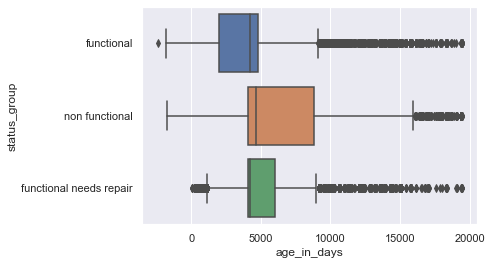

In [121]:
# verify if engineered age is a decent feature
sb.boxplot(x = 'age_in_days', y = 'status_group', data = pd.concat([numericData, response], axis = 1))

From above, it seems our approximation by median based on `region_code` is flawed as some `age_in_days` are negative. We will fill them with median of `age_in_days`
Also, let's look at density plots to find more meaningful insights.

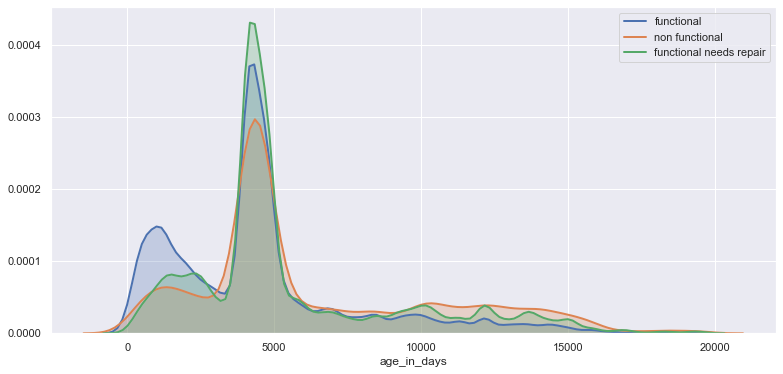

In [141]:
median = numericData['age_in_days'].median()
numericData['age_in_days'] = numericData['age_in_days'].apply(lambda x: median if x < 0 else x)
f, axes = plt.subplots(1, 1, figsize = (13, 6))
for level in response['status_group'].unique():
    sb.distplot(numericData[response['status_group']==level]['age_in_days'],
                hist=False,
                kde_kws = {'shade': True, 'linewidth': 2},
                label=level)

From the visualization, 
- density plot for 'functional' water pumps have a **higher area under the curve** below 2500 age_in_days. This suggests that below 2500 age_in_days, water pumps are more likely to be functional. 
- With the same concept, age_in_days between 4000 and 5000 water pumps are more likely to be needing repair. 
- Above 10000 age_in_days water pumps are more likely to be non-functional. We will use this engineered feature, age_in_days. 

<a id='standardizenumeric'></a>
### Standardize Numeric
- Here we will standardize numeric features to standard normal curve (gaussian) to keep everything on a similar scale
---
- <a href='#datacleaning'>Back to Data Cleaning</a>
- <a href='#top'>Back to top</a>

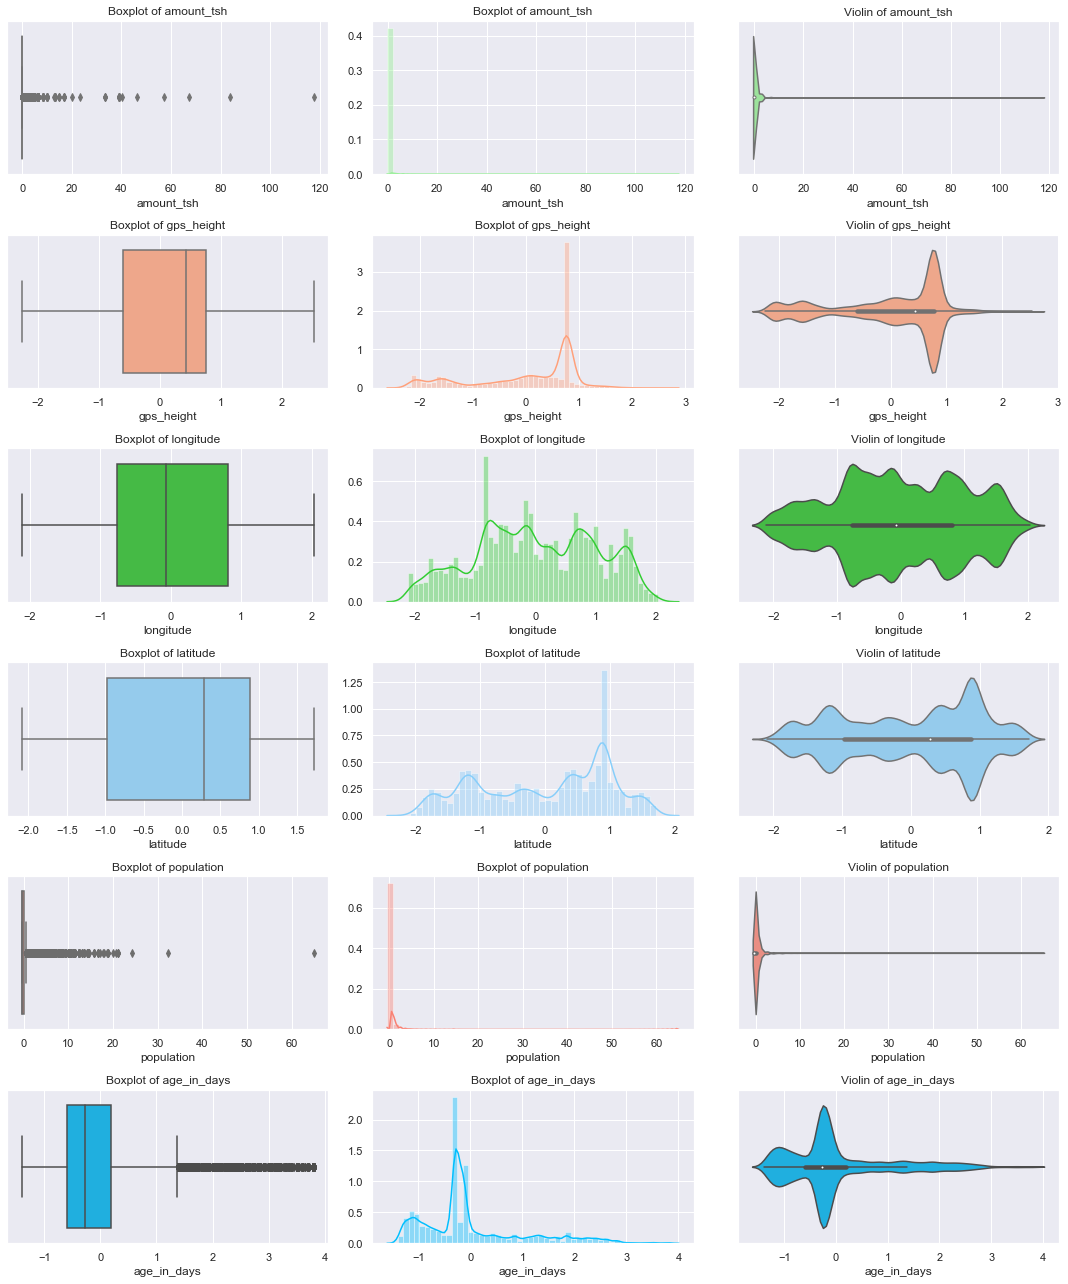

In [38]:
numericData = (numericData - numericData.mean()) / numericData.std()
univariate_numeric_plots(numericData, color_list)

As seen above, each feature is now on a similar scale

In [39]:
# collect features
features = pd.concat([numericData, categoricalData], axis = 1)
features.head()

,amount_tsh,gps_height,longitude,latitude,population,age_in_days,basin,public_meeting,permit,extraction_type_class,...,source_class,waterpoint_type,waterpoint_type_group,region,scheme_management,extraction_type,extraction_type_group,management,region_code,district_code
0,1.795819,0.218050,-0.056513,-1.445295,-0.182926,-0.207249,1,2,0,0,...,0,1,1,0,0,0,0,0,0,0
1,-0.056634,0.233118,-0.148797,1.306854,0.183750,-1.088595,4,1,2,0,...,1,1,1,2,2,0,0,1,3,0
2,-0.216618,-0.960603,0.916183,0.709266,0.119421,-0.993373,5,2,2,0,...,1,2,1,2,0,0,0,0,3,0
3,-0.056634,-1.668798,1.311611,-1.909045,-0.292286,1.246236,7,2,2,5,...,0,2,1,2,0,1,1,0,3,2
4,-0.056634,0.768869,-1.524575,1.421850,-0.330884,-0.272514,4,2,2,0,...,1,1,1,1,1,0,0,2,1,0


<a id='smote'></a>
### SMOTE
- Here we will apply SMOTE to rectify class imbalance
- we will perform one last visualization to have a sanity check on how well each feature is at distinguishing states of water pumps
---
- <a href='#datacleaning'>Back to Data Cleaning</a>
- <a href='#top'>Back to top</a>

In [40]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 1, sampling_strategy = 'not majority')
features, response = sm.fit_resample(features, response)
# round off artificially generated levels in categoric features to whole numbers
for col in features.iloc[:, 6:]:
    features[col] = features[col].apply(lambda x: round(x))
features.shape

Using TensorFlow backend.


(96777, 29)

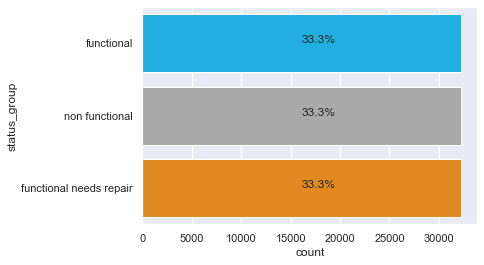

In [41]:
axes = sb.countplot(y = response['status_group'],palette=['deepskyblue','darkgrey','darkorange'])
total = len(response['status_group'])
for p in axes.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = (p.get_x() + p.get_width()) / 2
        y = p.get_y() + p.get_height()/2
        axes.annotate(percentage, (x, y))

In [42]:
# close figures to reduce memory strain
plt.close()

<a id='finalvisualization'></a>
### Final visualization
---
- <a href='#datacleaning'>Back to Data Cleaning</a>
- <a href='#top'>Back to top</a>

C:\Users\Nicholas\AppData\Roaming\Python\Python36\site-packages\seaborn\axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Wall time: 7.28 s


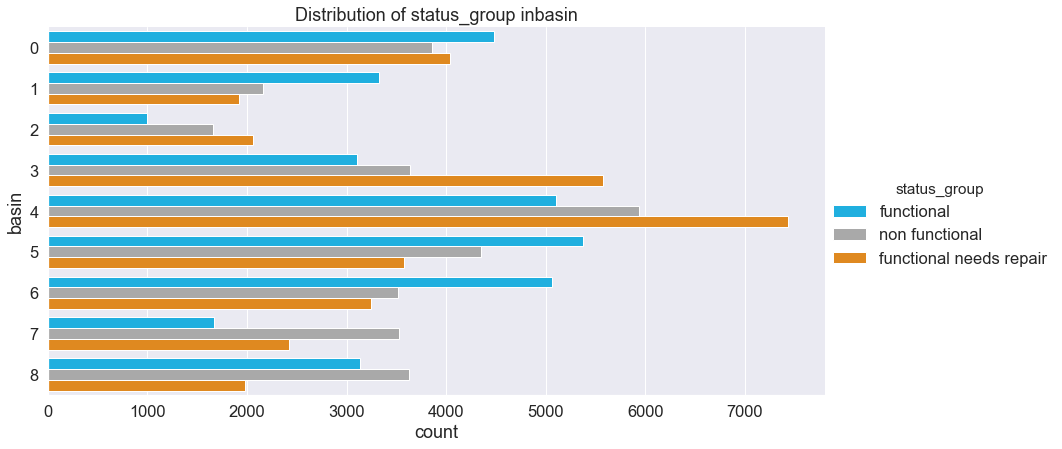

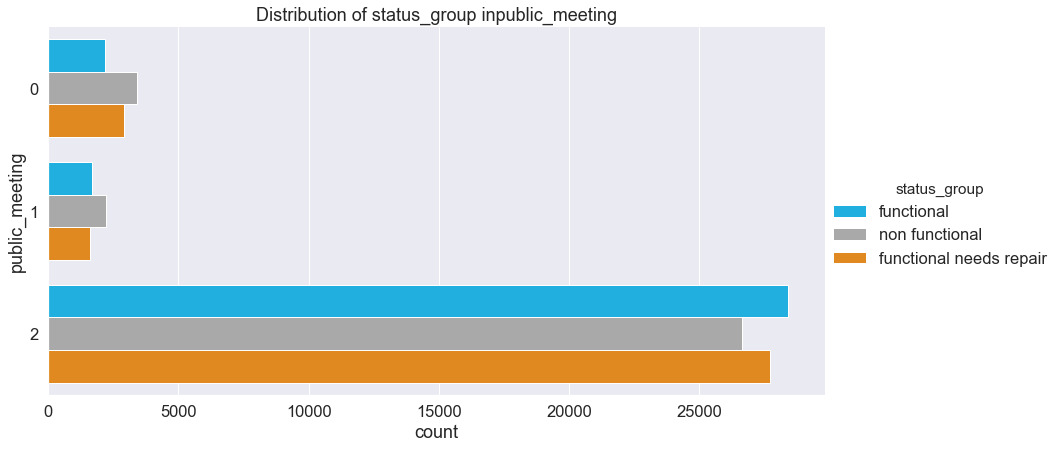

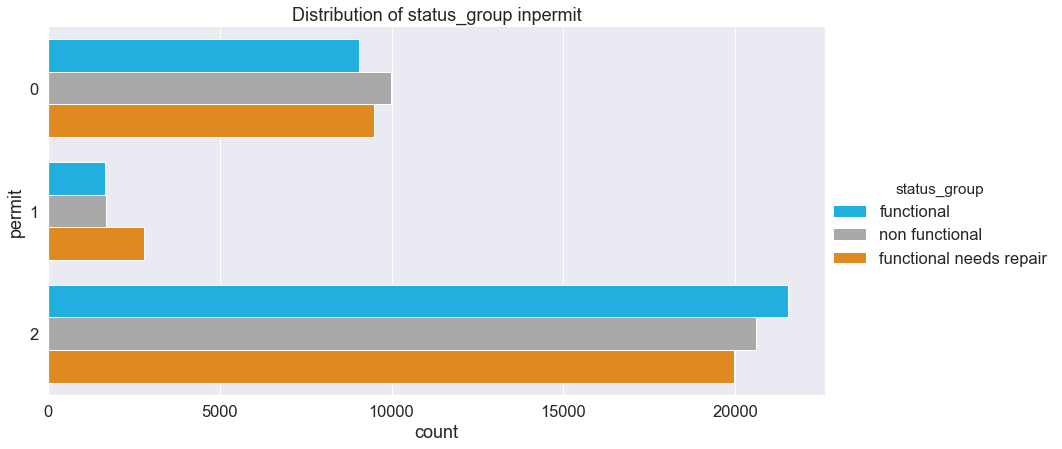

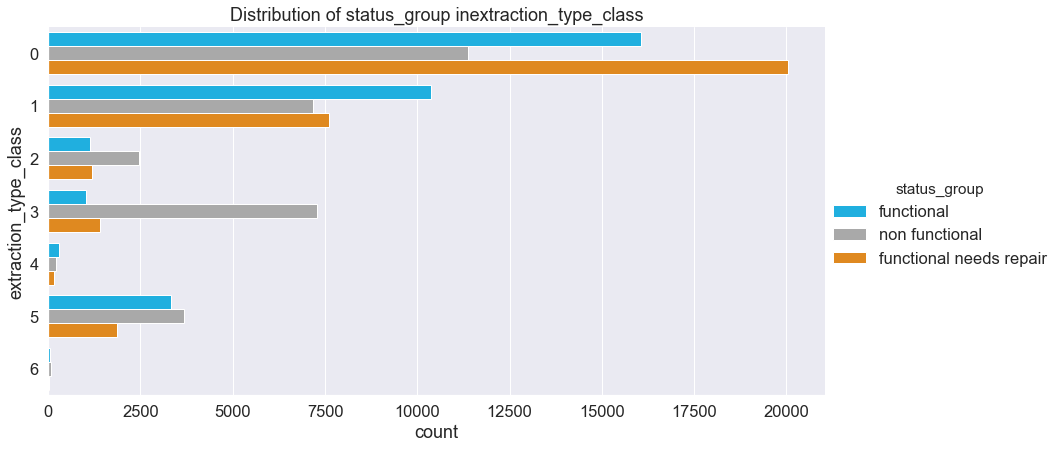

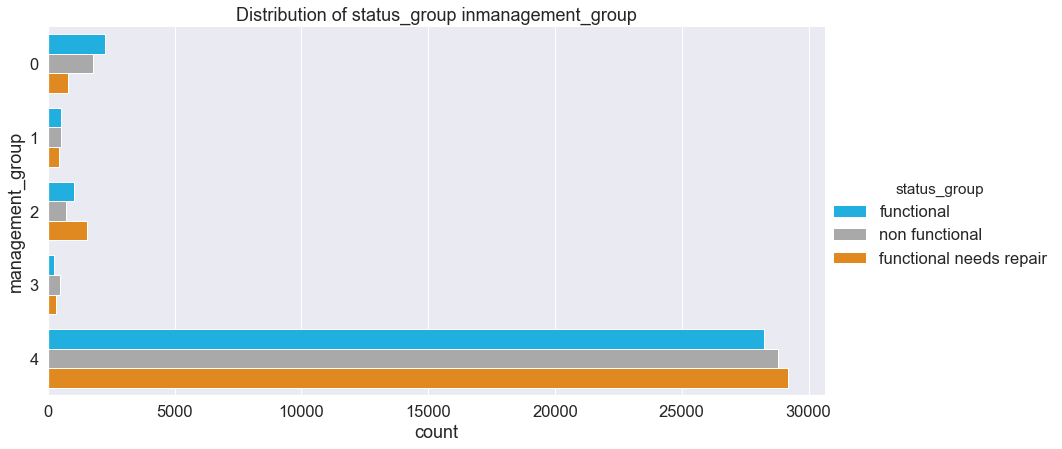

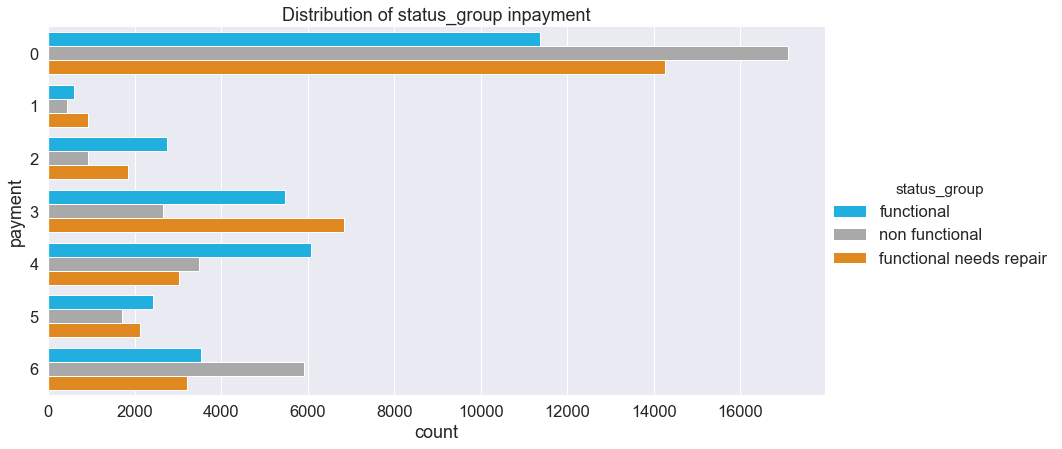

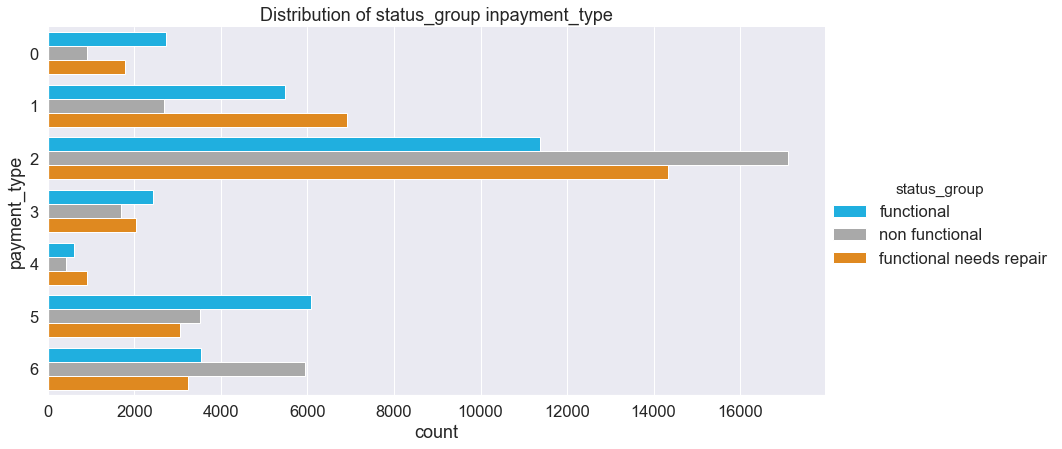

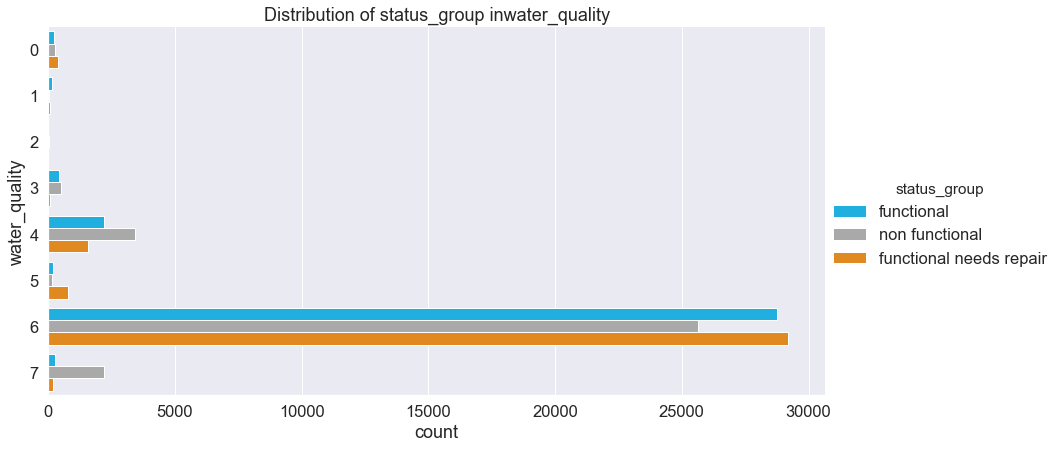

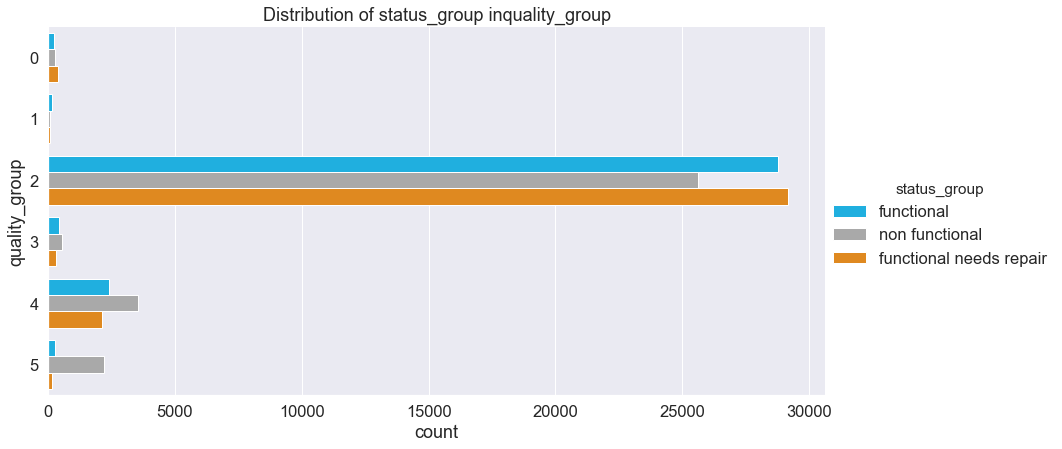

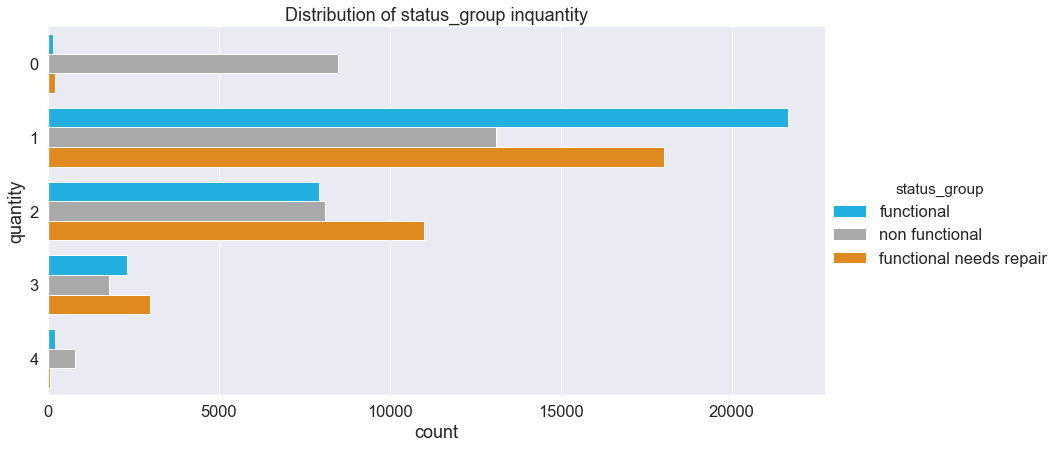

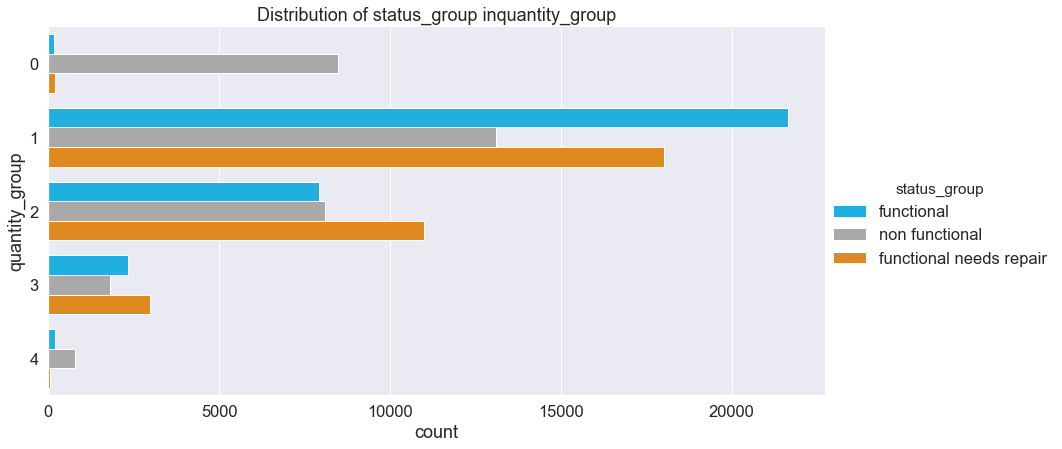

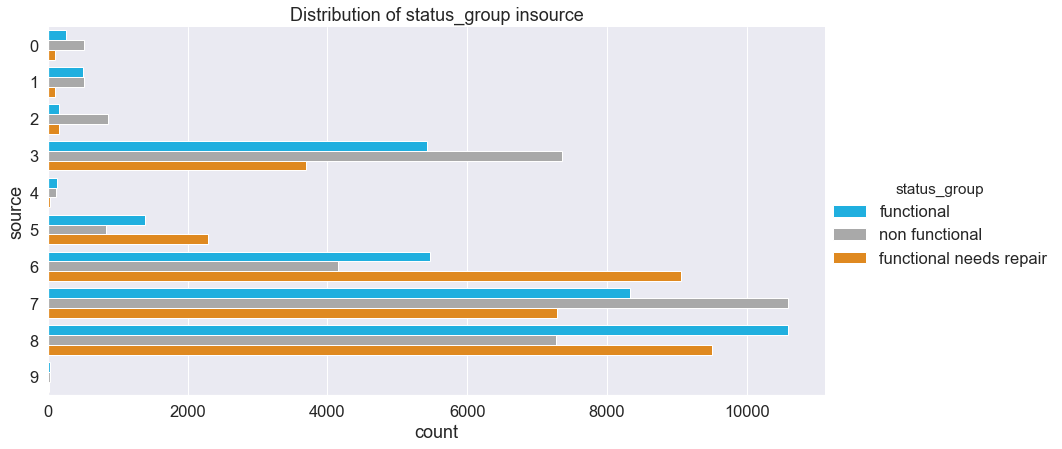

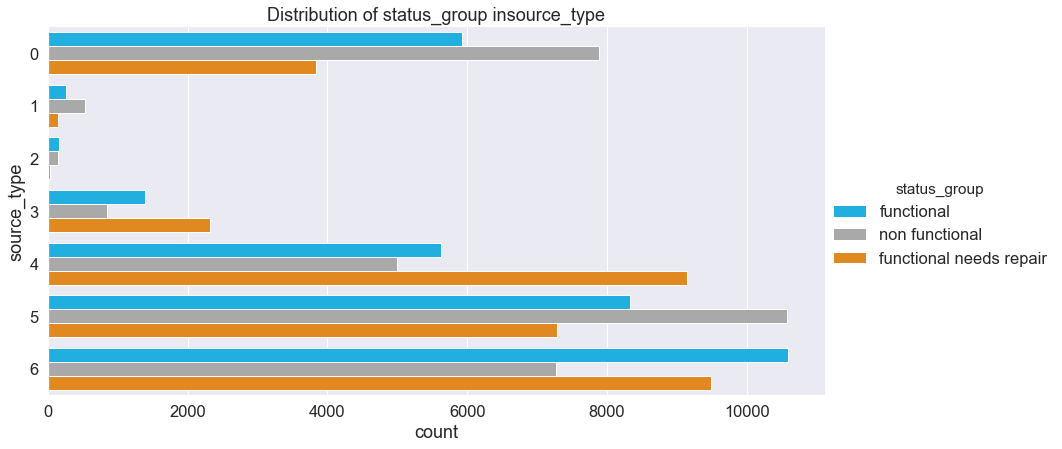

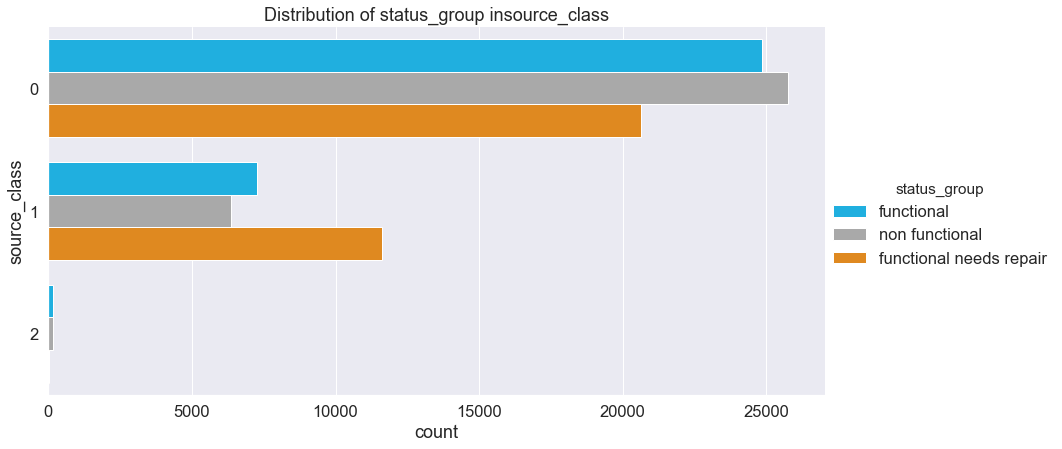

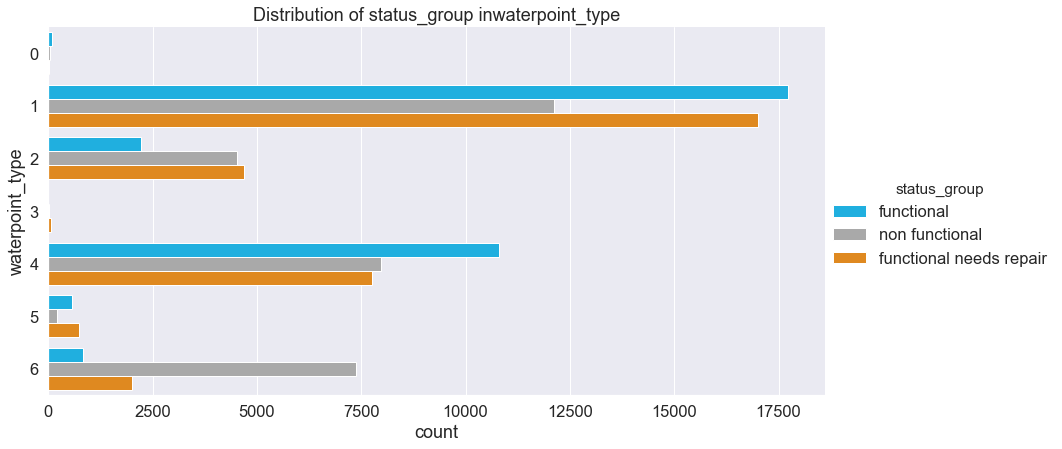

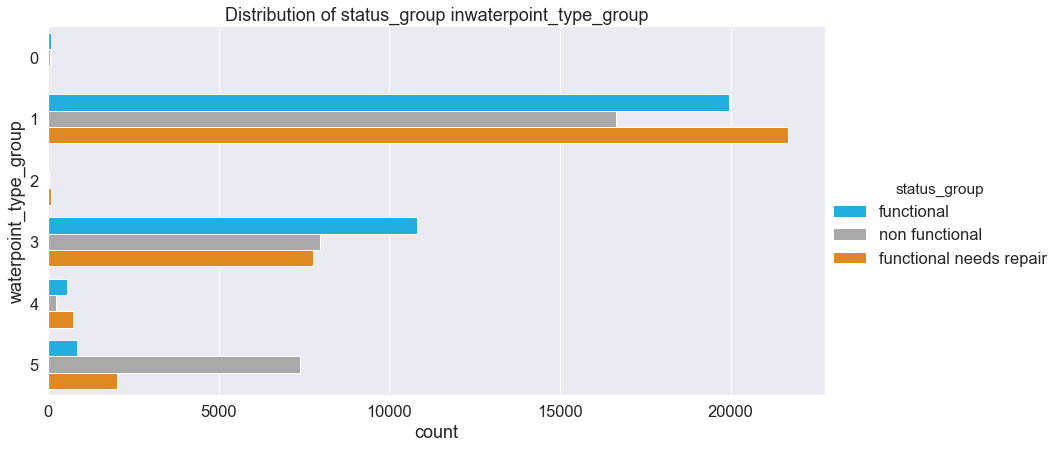

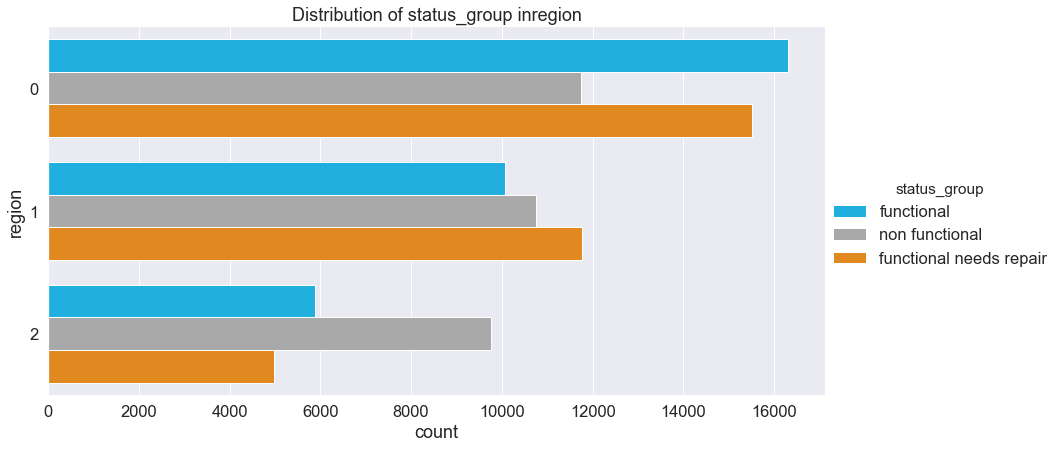

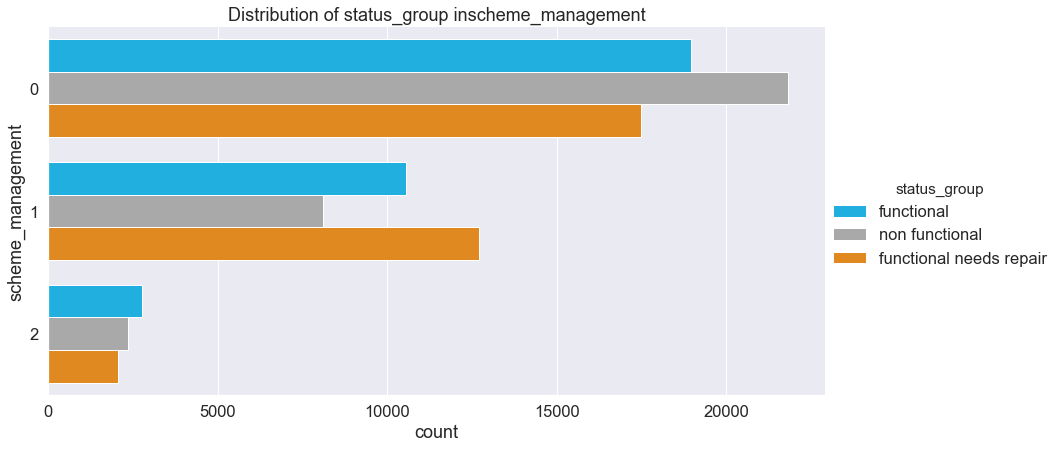

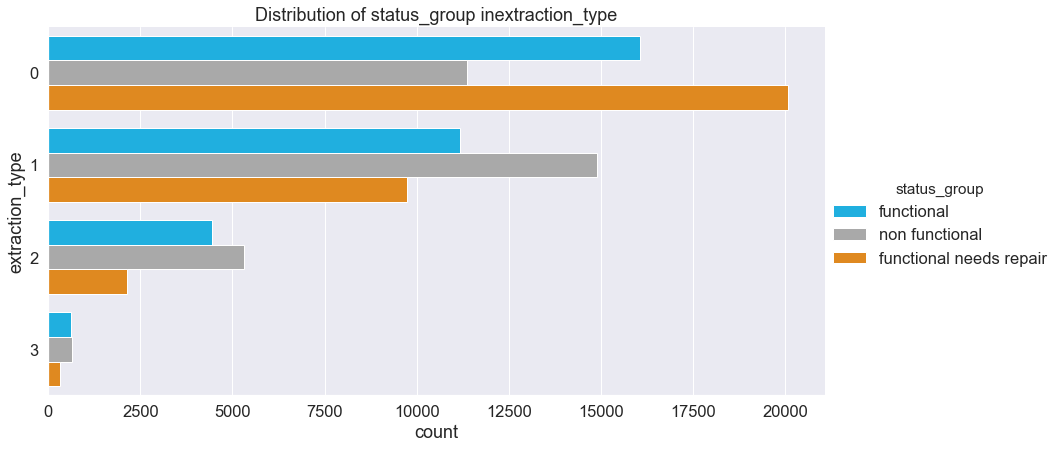

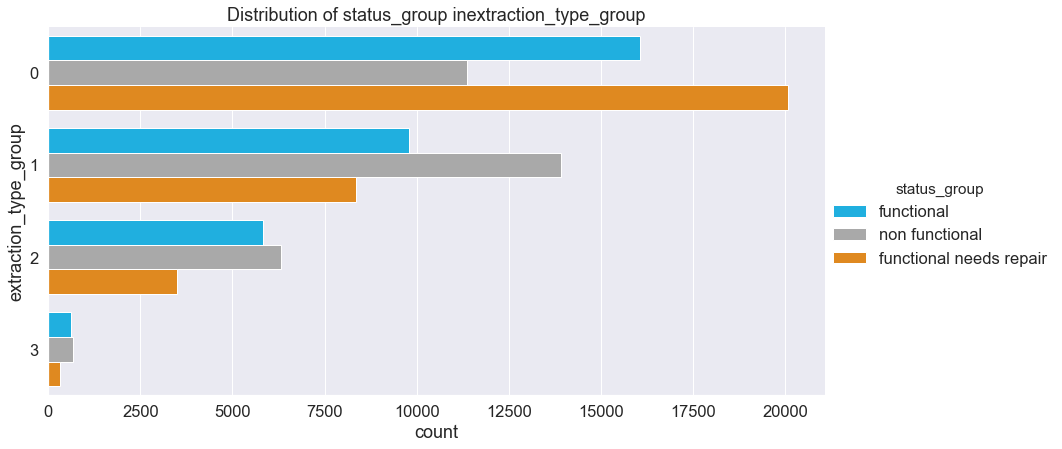

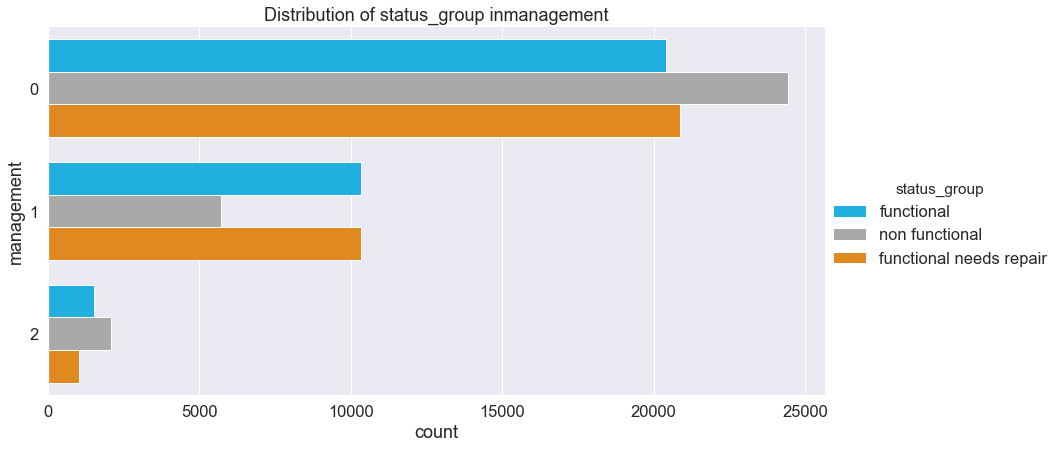

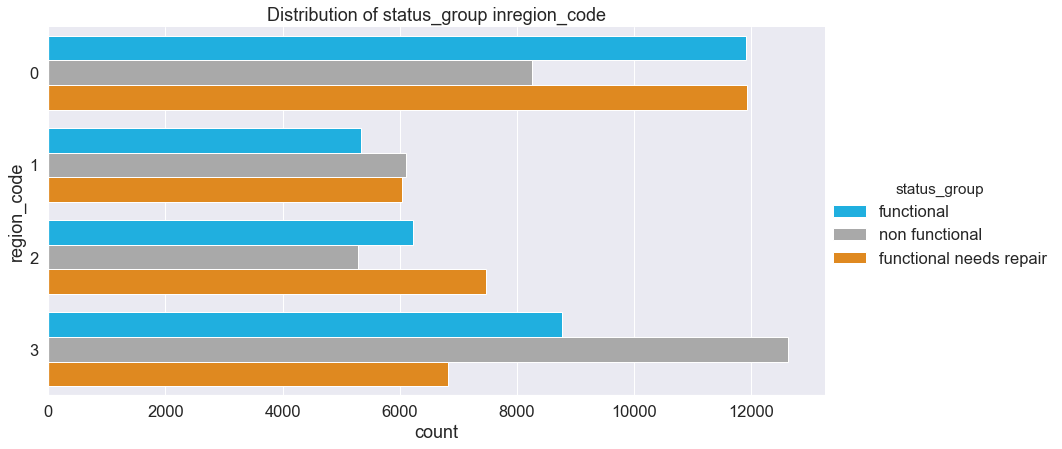

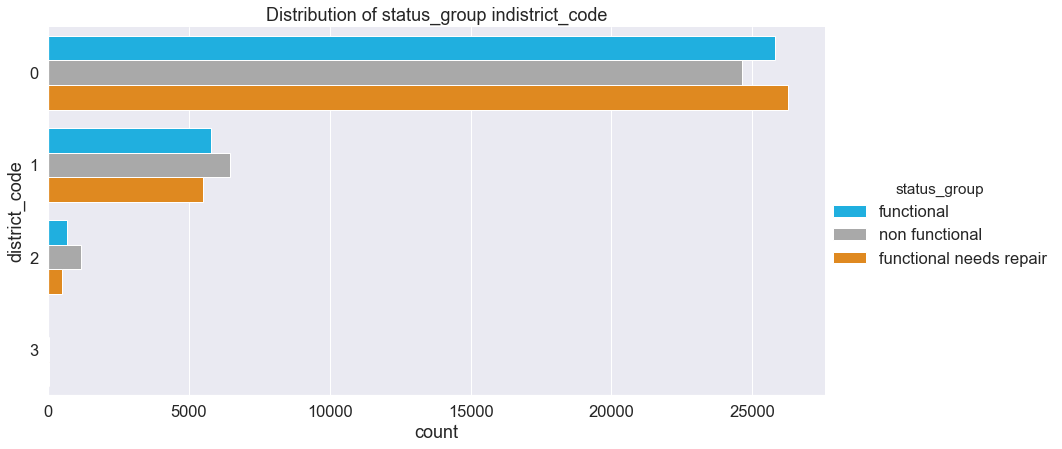

In [43]:
%%time
sb.set(font_scale=1.5)
features = pd.concat([features, response], axis = 1)
for col in features.iloc[:, 6:-1]:
    sb.catplot(y = col, hue='status_group',
               data = features,
               kind = "count", height = 6,aspect=2,
               palette=['deepskyblue','darkgrey','darkorange'])
    plt.title('Distribution of status_group in' + col)
features.pop('status_group')
sb.set()

From above, some features appear good at distinguishing between state of the water pumps.
- Looking at `extraction_type_class`, belonging to level `3` indicates that water pump is likely to be `non functional`

This may seem like a repeat of what was previously done way up above in the notebook. However, the distributions then were still skewed towards `functional`.

SMOTE rectifies this and now there is no bias to `functional` and thus any insight like the one stated at the top of this cell, is more meaningful

<a id='model'></a>
## Model
- <a href='#ohevsle'>One Hot Encoding vs Label Encoding</a>
- <a href='#metricforoptimization'>Metric for Optimization</a>
- <a href='#auroc'>Area under ROC curve</a>
- <a href='#clustering'>Clustering</a>
    - <a href='#minibatchkmeans'>MiniBatchKMeans</a>
    - <a href='#dbscan'>DBSCAN</a>
---
<a href='#top'>Back to top</a>

First we try out a few models to establish baseline to beat

In [44]:
dummies = pd.get_dummies(features.iloc[:, 6:].astype('object'))
dummies = pd.concat([features.iloc[:, :6], dummies], axis = 1)
dummies.head()

,amount_tsh,gps_height,longitude,latitude,population,age_in_days,basin_0,basin_1,basin_2,basin_3,...,management_1,management_2,region_code_0,region_code_1,region_code_2,region_code_3,district_code_0,district_code_1,district_code_2,district_code_3
0,1.795819,0.218050,-0.056513,-1.445295,-0.182926,-0.207249,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,-0.056634,0.233118,-0.148797,1.306854,0.183750,-1.088595,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
2,-0.216618,-0.960603,0.916183,0.709266,0.119421,-0.993373,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,-0.056634,-1.668798,1.311611,-1.909045,-0.292286,1.246236,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,-0.056634,0.768869,-1.524575,1.421850,-0.330884,-0.272514,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0


Here we use `precision` as a baseline to determine which model is the best.

More on the metric chosen later

In [45]:
%%time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support as precision
from sklearn.model_selection import RepeatedKFold

models = [RandomForestClassifier(random_state = 1), KNeighborsClassifier(n_jobs = -1),
          GradientBoostingClassifier(random_state = 1)]
results = {'names': ['RForest', 'KNC', 'GBC']}
for i, model in enumerate(models):
    name = results['names'][i]
    results[name] = []
    print('Training', name)
    folds = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    for train_idx, test_idx in folds.split(dummies):
        X_train, X_test = dummies.iloc[train_idx], dummies.iloc[test_idx]
        y_train, y_test = response.iloc[train_idx], response.iloc[test_idx]
        model.fit(X_train, y_train.values.ravel())
        results[name].append(round(precision(y_test, model.predict(X_test), average='weighted')[0], 3))
results.pop('names')
results = pd.DataFrame.from_dict(results)
for col in results:
    print(f'{col}, mean precision: {round(results.mean()[col], 3)}, std: {round(results.std()[col], 3)}')

Training RForest
Training KNC
Training GBC
RForest, mean precision: 0.861, std: 0.001
KNC, mean precision: 0.81, std: 0.003
GBC, mean precision: 0.696, std: 0.002
Wall time: 10min 30s


In [46]:
%%time
models = [RandomForestClassifier(random_state = 1), KNeighborsClassifier(n_jobs = -1),
          GradientBoostingClassifier(random_state = 1)]
results = {'names': ['RForest', 'KNC', 'GBC']}
for i, model in enumerate(models):
    name = results['names'][i]
    results[name] = []
    print('Training', name)
    folds = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    for train_idx, test_idx in folds.split(features):
        X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
        y_train, y_test = response.iloc[train_idx], response.iloc[test_idx]
        model.fit(X_train, y_train.values.ravel())
        results[name].append(round(precision(y_test, model.predict(X_test), average='weighted')[0], 3))
results.pop('names')
results = pd.DataFrame.from_dict(results)
for col in results:
    print(f'{col}, mean precision: {round(results.mean()[col], 3)}, std: {round(results.std()[col], 3)}')

Training RForest
Training KNC
Training GBC
RForest, mean precision: 0.863, std: 0.002
KNC, mean precision: 0.806, std: 0.001
GBC, mean precision: 0.693, std: 0.001
Wall time: 5min 58s


<a id='ohevsle'></a>
### One Hot Encoding vs Label Encoding

In theory:
- One Hot Encoding (OHE) is used for nominal data as it represents the presence of a level by `1` or `0`
- Label Encoding (LE) is used for ordinal data as it represents some order between levels such as `2` is better than `1`

Given that our data is only numeric and categoric, it would seem that OHE should be preferred.

---
From the above results:
- models have low variance, suggesting that they are robust
- `RForest` outperforms the other 2 models
- Performance with OHE and LE are similar

Since cross validation (with random seed for reproducibility) is used in all the above training, this difference cannot be attributed to random chance. In other words, LE could not have outperformed (although by a small margin) OHE by chancing upon a more forgiving test set.

---

Since LE outperforms OHE by a little and is twice as fast, we will be using and optimizing `RForest` and LE from now on

<a id='metricforoptimization'></a>
### Metric for Optimization
There many metrics to evalute our model on such as:
- accuracy
- precision
- recall
-  area under roc curve (auroc)

We choose to optimize for `auroc` as we want to have the greatest distinction between True Positives and True Negatives. In other words, we want to be sure when the model predicts a water pump to be `non functional` and sure that it is not `functional`. In a real world context, this will be very beneficial to local authorities as it reduces time and labor costs to be dispatched to fix or replace water pumps.

---
- <a href='#model'>Back to Model</a>
- <a href='#top'>Back to top</a>

In [47]:
%%time
from sklearn.model_selection import RandomizedSearchCV
# try models with these parameters and choosing best
parameters = {'min_samples_leaf': range(1, 21, 5),
              'min_samples_split': range(2, 43, 10)}
model = RandomForestClassifier(random_state=1)
model = RandomizedSearchCV(model, parameters, scoring='roc_auc_ovr', cv = 5, n_iter = 10) # f1_weighted
model.fit(features, response.values.ravel())
best_precision = round(model.best_score_, 3)
best_std = model.cv_results_["std_test_score"].std()
print(f'Best AUROC: {best_precision}, AUROC std: {best_std}')
# baseline to beat
best_model = model.best_estimator_

Best AUROC: 0.956, AUROC std: 0.0006798005227531741
Wall time: 8min 30s


Text(0.5, 1.0, 'Overall AUROC: 0.996')

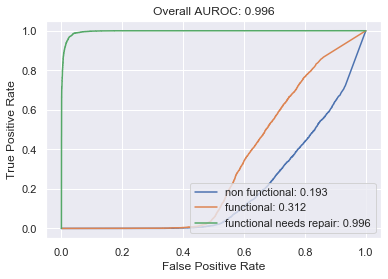

In [48]:
from sklearn.metrics import roc_curve, auc
def visualize_auroc(y_true, X_test, model):
    for pos_label in y_true['status_group'].unique():
        fpr, tpr, thr = roc_curve(y_true, model.predict_proba(X_test)[:,1], pos_label = pos_label)
        auroc = round(auc(fpr, tpr), 3)
        plt.plot(fpr, tpr, label = f'{pos_label}: {auroc}')
    plt.legend(loc = 'lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    return f'Overall AUROC: {auroc}'
plt.title(visualize_auroc(y_test, X_test, best_model))

<a id='auroc'></a>
### Visualize Area under ROC
As seen above:
- overall auroc is very high
- auroc for `functional needs repair` is very high
- however auroc for `functional` and `non functional` is quite low

This means the model is competent in distinguishing between True `functional needs repair` and True `functional` or `non functional`. On the other hand, it is also rather incompetent in distinguishing between `functional` and the rest and `non functional` and the rest.

Ideally, the model should have high auroc for all classes meaning compentency in distinguishing bewtween each class but being able to distinguish `functional needs repair` against the rest is still quite beneficial as it allows for resources to be allocated for repairing of such water pumps.

---
However, can we do better with clustering?

---
- <a href='#model'>Back to Model</a>
- <a href='#top'>Back to top</a>

<a id='clustering'></a>
### Clustering
- clusters may have different distributions from one another but similar distributions within each cluster
- this may help increase AUROC as model is more able to distinguish between states of water pumps within each cluster

Below we visualize longitude and latitude to see if there is any meaning clusters

- <a href='#minibatchkmeans'>MiniBatchKMeans</a>
- <a href='#dbscan'>DBSCAN</a>
---
- <a href='#model'>Back to Model</a>
- <a href='#top'>Back to top</a>

In [146]:
%%HTML
<div class='tableauPlaceholder' id='viz1585300577543' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;HH&#47;HHH895ZGX&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;HHH895ZGX' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;HH&#47;HHH895ZGX&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1585300577543');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

As seen above, there isn't really any meaningful cluster to be seen. However, there may still exist clusters as we have only visualized 2 out of 5 geo related features. In other words, 5 dimensional clusters may exist and cannot be seen in the 2 dimensional visualization above

In [46]:
# collect geo-related features for clustering into n models to hopefully increase auroc
geo_related = ['gps_height', 'longitude', 'latitude', 'district_code', 'basin']
geoFeatures = features[geo_related]
geoFeatures.head()

,gps_height,longitude,latitude,district_code,basin
0,0.218050,-0.056513,-1.445295,0,1
1,0.233118,-0.148797,1.306854,0,4
2,-0.960603,0.916183,0.709266,0,5
3,-1.668798,1.311611,-1.909045,2,7
4,0.768869,-1.524575,1.421850,0,4


- <a id='minibatchkmeans'></a>
Here we attempt to find the optimal number of clusters for the geo-related features.

MiniBatchKMeans is used as we have quite a large dataset (almost 100,000)

---
- <a href='#model'>Back to Model</a>
- <a href='#clustering'>Back to Clustering</a>
- <a href='#top'>Back to top</a>

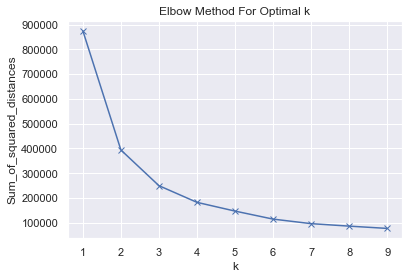

In [47]:
from sklearn.cluster import MiniBatchKMeans, DBSCAN
# check optimal clusters for kmeans
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = MiniBatchKMeans(n_clusters=k)
    km = km.fit(geoFeatures)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We feel that the drop in `Sum_of_squared_distances` from `k = 4` to `k = 5` is the sharpest increase in gradient, indicating that `k = 5` is probably the optimal number of clusters

In [52]:
# fit kmeans to optimal clusters. predict clusters for train and test
kmeans = MiniBatchKMeans(n_clusters = 5, init='k-means++')
kmeans.fit(geoFeatures)
pred = kmeans.predict(geoFeatures)

In [53]:
# add engineered feature
features['clusters_kmeans'] = pred
features['clusters_kmeans'].value_counts()

0    30342
3    22064
1    19428
4    12523
2    12420
Name: clusters_kmeans, dtype: int64

From above we see some clusters are bigger than others

C:\Users\Nicholas\AppData\Roaming\Python\Python36\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


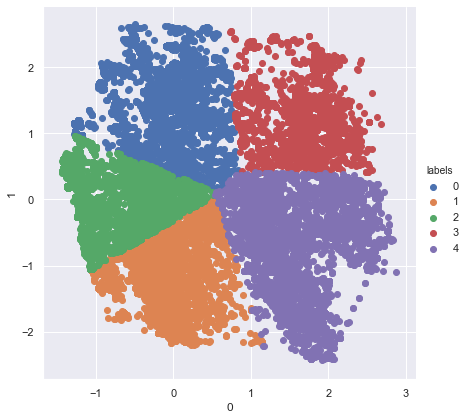

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
X_pca = pca.fit_transform(features)

km = MiniBatchKMeans(n_clusters=5)
km.fit(X_pca)
df = pd.DataFrame(X_pca)
df.rename(columns={0:'PCA_1', 1:'PCA_2'})
df['labels'] = km.predict(X_pca)
sb.FacetGrid(df, hue="labels", size=6).map(plt.scatter, 0, 1).add_legend()
plt.show()

From above we can see that clustering all 5 features in 5 dimensional space and compressing it down to 2 dimensions, there appears to be 5 distinct clusters based on these geoFeatures

<a id='dbscan'></a>
### DBSCAN

We also try using DBSCAN for clustering

---
- <a href='#model'>Back to Model</a>
- <a href='#clustering'>Back to Clustering</a>
- <a href='#top'>Back to top</a>

In [54]:
%%time
for eps in [1, 1.01]:
    dbscan = DBSCAN(eps = eps, min_samples = 5, n_jobs = -1)
    db = dbscan.fit(geoFeatures)
    db_labels = db.labels_

    n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    n_noise_ = list(db.labels_).count(-1)
    print(f'outliers: {n_noise_}')
    print(f'n_clusters_: {n_clusters_}')

# add engineered feature
features['clusters_dbscan'] = db_labels
features['clusters_dbscan'].value_counts()

outliers: 13
n_clusters_: 24
outliers: 12
n_clusters_: 1
Wall time: 1min 14s


 0    96765
-1       12
Name: clusters_dbscan, dtype: int64

Using the above 2 values of `eps` which dictates the distance between points to consider if a point belongs to a cluster, `DBSCAN` detect very different number of clusters. The former result yields `25` clusters which we feel is overfitting to the model based on our intuition and the results from `MiniBatchKMeans`. As such we will keep the latter result of `1` cluster and `11` outliers for `DBSCAN`

In [55]:
# save a copy, drop geo_related features from feature space
copyFeatures = features.copy()
features.drop(columns = geo_related, inplace = True)
features.head()

,amount_tsh,population,age_in_days,public_meeting,permit,extraction_type_class,management_group,payment,payment_type,water_quality,...,waterpoint_type,waterpoint_type_group,region,scheme_management,extraction_type,extraction_type_group,management,region_code,clusters_kmeans,clusters_dbscan
0,1.795819,-0.182926,-0.207249,2,0,0,4,2,0,6,...,1,1,0,0,0,0,0,0,4,0
1,-0.056634,0.183750,-1.088595,1,2,0,4,0,2,6,...,1,1,2,2,0,0,1,3,0,0
2,-0.216618,0.119421,-0.993373,2,2,0,4,4,5,6,...,2,1,2,0,0,0,0,3,3,0
3,-0.056634,-0.292286,1.246236,2,2,5,4,0,2,6,...,2,1,2,0,1,1,0,3,1,0
4,-0.056634,-0.330884,-0.272514,2,2,0,1,0,2,6,...,1,1,1,1,0,0,2,1,0,0


In [56]:
# combine features and response so easier to extract clusters later
features = pd.concat([features, response],axis=1)

Here we separate the features and response into each cluster and store them into a dictionary for easier access later.

- DBSCAN only has 1 cluster, with 11 outliers. We will ignore the outliers and only train on the single identified cluster.
- this is because 11 points are not enough to train a single model on

In [57]:
cluster_kmeans = {}
for i in range(len(features['clusters_kmeans'].unique())):
    condition = features['clusters_kmeans'] == i
    cluster_kmeans['cluster_kmeans_' + str(i)] = features[condition]
cluster_dbscan = {}
for i in range(1):
    condition = features['clusters_dbscan'] == i
    cluster_dbscan['cluster_dbscan_' + str(i)] = features[condition]

In [58]:
def train_cluster_models(cluster_dict, results):
    for cluster_name, clusteredFeatures in cluster_dict.items():
        print(f'Training model_{cluster_name.split("_")[-1]} on {cluster_name}')
        cluster_response = clusteredFeatures['status_group']
        clusteredFeatures = clusteredFeatures.drop(columns = ['status_group'])
        # cross valdate on best params found
        parameters = {'min_samples_leaf': [1],
                      'min_samples_split': [12]}
        rforest = RandomForestClassifier(random_state=1)
        rforest = RandomizedSearchCV(rforest, parameters, scoring='roc_auc_ovr', cv = 5, n_iter = 1)
        rforest.fit(clusteredFeatures, cluster_response.values.ravel())
        
        results['auroc_ovr'].append(rforest.best_score_)
        results['names'].append(cluster_name)            
    return results

In [59]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
results = {'names': [], 'auroc_ovr': []}

results = train_cluster_models(cluster_kmeans, results)

Training model_0 on cluster_kmeans_0
Training model_1 on cluster_kmeans_1
Training model_2 on cluster_kmeans_2
Training model_3 on cluster_kmeans_3
Training model_4 on cluster_kmeans_4
Wall time: 40.3 s


In [60]:
def summarize(results):
    results = pd.DataFrame.from_dict(results)
    mean = round(results.mean()["auroc_ovr"], 3)
    std = round(results.std()["auroc_ovr"], 3)
    print(f'Mean auroc: {mean}, auroc std: {std}')
    return results

In [61]:
summarize(results)

Mean auroc: 0.945, auroc std: 0.007


,names,auroc_ovr
0,cluster_kmeans_0,0.936842
1,cluster_kmeans_1,0.951877
2,cluster_kmeans_2,0.940923
3,cluster_kmeans_3,0.939786
4,cluster_kmeans_4,0.953260


In [62]:
%%time
results = {'names': [], 'auroc_ovr': []}

results = train_cluster_models(cluster_dbscan, results)
summarize(results)

Training model_0 on cluster_dbscan_0
Mean auroc: 0.944, auroc std: nan
Wall time: 51.7 s


,names,auroc_ovr
0,cluster_dbscan_0,0.94417


From above:
- either clustering technique does not seem to make a huge difference in auroc
- both have high auroc and low std

Since model trained on features without clustering has higher AUROC and lower std, it appears to be able to distinguish between the states of the water pumps better and is robust with little variance. This will be our final model of choice

See best_model <a href='#metricforoptimization'>here</a> again

<a id='references'></a>
### References

- https://medium.com/analytics-vidhya/principal-component-analysis-pca-with-code-on-mnist-dataset-da7de0d07c22
- https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
- https://www.jamesmaino.com/post/simple-intuitive-explanation-of-roc-and-auc-curves/
- https://medium.com/@swethalakshmanan14/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff

---
Data taken from:

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

<a id='end'></a>
# End
<a href='#top'>Back to top</a>